<a href="https://colab.research.google.com/github/BogdanT54/Cicluri-Economice-si-Randamentul-Pietelor/blob/main/Analiza_Active_Licenta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install yfinance statsmodels arch seaborn rpy2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.8 MB/s eta 0:00:00


In [3]:
# Importuri
from datetime import timedelta
import yfinance as yf
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import statsmodels.tsa.stattools as ts
from google.colab import files
from arch.unitroot import ADF, PhillipsPerron, KPSS
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.dates as mdates
import warnings
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import kurtosis, skew
import numpy as np
import pandas as pd
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

# **Citire, prelucrare si curatare date**

In [33]:
#Fac un dataframe cu fisierul dat
sp500 = yf.download('^GSPC', start='2005-01-01', end='2025-12-30', interval='1d')
gold = yf.download('GC=F', start='2005-01-01', end='2025-12-30', interval='1d')
oil = yf.download('CL=F', start='2005-01-01', end='2025-12-30', interval='1d')

bitcoin = pd.read_csv ('Bitcoin.csv', index_col=0, parse_dates=True)


#Citire, curatare si prelucrare date ROTX
rotx = pd.read_csv('ROTX.csv', sep=';', index_col=0, parse_dates=True)
rotx = rotx.loc[:, ~rotx.columns.str.contains('^Unnamed')]
rotx.drop(columns=['Chg.%'], inplace=True)
rotx.rename(columns={'Last Close': 'Close'}, inplace=True)

oil.to_csv('CL=F.csv')
gold.to_csv('GC=F.csv')
sp500.to_csv('^GSPC.csv')

#Verific Df-ul
bitcoin.head(-1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,volume,marketCap
Period,,,,,,
2010-07-14,0.058157,0.061588,0.048647,0.056402,2.615400e+02,1.902596e+05
2010-07-15,0.056403,0.067954,0.053969,0.057568,4.458000e+02,1.959821e+05
2010-07-16,0.058001,0.072220,0.057484,0.066492,4.972500e+02,2.280474e+05
2010-07-17,0.066500,0.077735,0.057418,0.065993,1.999000e+01,2.269048e+05
2010-07-18,0.066088,0.080858,0.064221,0.078814,7.513000e+01,2.716692e+05
...,...,...,...,...,...,...
2025-05-20,105434.368300,105997.692300,104232.699900,104731.983300,4.454486e+10,2.081860e+12
2025-05-21,104750.780100,105936.690200,100436.885900,101575.952300,5.747930e+10,2.018780e+12
2025-05-22,101574.367100,105376.773400,101169.572400,104390.346900,4.885665e+10,2.074800e+12


In [8]:
# Extragere coloana 'Close' și redenumire
sp500_close = sp500['Close']
gold_close = gold['Close']
oil_close = oil['Close']
bitcoin_close = bitcoin['Close']
rotx_close = rotx['Close']

# Concatenare
real_prices_df = pd.concat([sp500_close, gold_close, oil_close, bitcoin_close, rotx_close], axis=1)
real_prices_df.columns = ['SP500', 'Gold', 'Oil', 'Bitcoin', 'ROTX']

# Vizualizare
real_prices_df.head()

,SP500,Gold,Oil,Bitcoin,ROTX
2005-01-03,1202.079956,428.700012,42.119999,NaN,NaN
2005-01-04,1188.050049,428.500000,43.910000,NaN,NaN
2005-01-05,1183.739990,426.600006,43.389999,NaN,NaN
2005-01-06,1187.890015,421.000000,45.560001,NaN,NaN
2005-01-07,1186.189941,418.899994,45.430000,NaN,NaN


In [9]:
# Prelucrare randamente + logaritmare cu backfill
sp500_log_returns = np.log(sp500 / sp500.shift(1)).replace([np.inf, -np.inf, 0], np.nan).dropna().bfill()
gold_log_returns = np.log(gold / gold.shift(1)).replace([np.inf, -np.inf, 0], np.nan).dropna().bfill()
oil_log_returns = np.log(oil / oil.shift(1)).replace([np.inf, -np.inf, 0], np.nan).dropna().bfill()
bitcoin_log_returns = np.log(bitcoin / bitcoin.shift(1)).bfill()
rotx_log_returns = np.log(rotx / rotx.shift(1)).replace([np.inf, -np.inf, 0], np.nan).dropna().bfill()


sp500_log_returns_close = sp500_log_returns['Close']
gold_log_returns_close = gold_log_returns['Close']
oil_log_returns_close = oil_log_returns['Close']
bitcoin_log_returns_close = bitcoin_log_returns['Close']
rotx_log_returns_close = rotx_log_returns['Close']

log_real_prices_df = pd.concat([sp500_log_returns_close, gold_log_returns_close, oil_log_returns_close, bitcoin_log_returns_close, rotx_log_returns_close], axis=1)
log_real_prices_df.columns = ['SP500', 'Gold', 'Oil', 'Bitcoin', 'ROTX']

log_real_prices_df.head(-1)

,SP500,Gold,Oil,Bitcoin,ROTX
2005-01-04,-0.011740,-0.000467,0.041619,NaN,NaN
2005-01-05,-0.003634,-0.004444,-0.011913,NaN,NaN
2005-01-06,0.003500,-0.013214,0.048801,NaN,NaN
2005-01-07,-0.001432,NaN,-0.002857,NaN,NaN
2005-01-10,0.003417,NaN,-0.002204,NaN,NaN
...,...,...,...,...,...
2025-06-06,0.010228,-0.008392,0.018914,NaN,-0.000122
2025-06-09,0.000920,0.002825,0.010934,NaN,NaN
2025-06-10,0.005468,-0.003367,-0.004759,NaN,NaN
2025-06-11,-0.002748,0.000120,0.047632,NaN,NaN


In [10]:
statistics = real_prices_df.describe()

# adaugam explicit linia 'median'
statistics.loc['median'] = real_prices_df.median()

# ordonam liniile ca sa apara median dupa mean
statistics = statistics.reindex(['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max'])

statistics.head(20)

,SP500,Gold,Oil,Bitcoin,ROTX
count,5145.000000,5139.000000,5143.000000,5430.000000,5047.000000
mean,2428.842044,1376.512901,71.768971,16343.879548,17531.368474
median,2016.709961,1300.699951,70.500000,4093.017227,15909.560000
std,1359.109960,537.778644,21.234701,24523.932324,8181.446556
min,676.530029,412.600006,-37.630001,0.056402,3440.980000
25%,1316.630005,1093.000000,55.720001,241.913502,11797.705000
50%,2016.709961,1300.699951,70.500000,4093.017227,15909.560000
75%,3191.139893,1729.250000,87.400002,24316.460773,20707.915000
max,6144.149902,3431.199951,145.289993,111673.284000,41843.420000


In [11]:
statistics = log_real_prices_df.describe()

# adaugam explicit linia 'median'
statistics.loc['median'] = log_real_prices_df.median()

# ordonam liniile ca sa apara median dupa mean
statistics = statistics.reindex(['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max'])

statistics.head(20)

,SP500,Gold,Oil,Bitcoin,ROTX
count,5109.000000,4699.000000,5052.000000,5430.000000,5008.000000
mean,0.000321,0.000377,0.000138,0.002672,0.000231
median,0.000733,0.000511,0.001112,0.001916,0.000764
std,0.012222,0.011300,0.025883,0.048348,0.014595
min,-0.127652,-0.098206,-0.282206,-0.675195,-0.196532
25%,-0.004103,-0.004967,-0.012536,-0.012682,-0.005275
50%,0.000733,0.000511,0.001112,0.001916,0.000764
75%,0.005731,0.006305,0.013087,0.018720,0.006439
max,0.109572,0.086432,0.223940,0.395243,0.104292


# **Analiza Descriptiva**

# **Multiple**

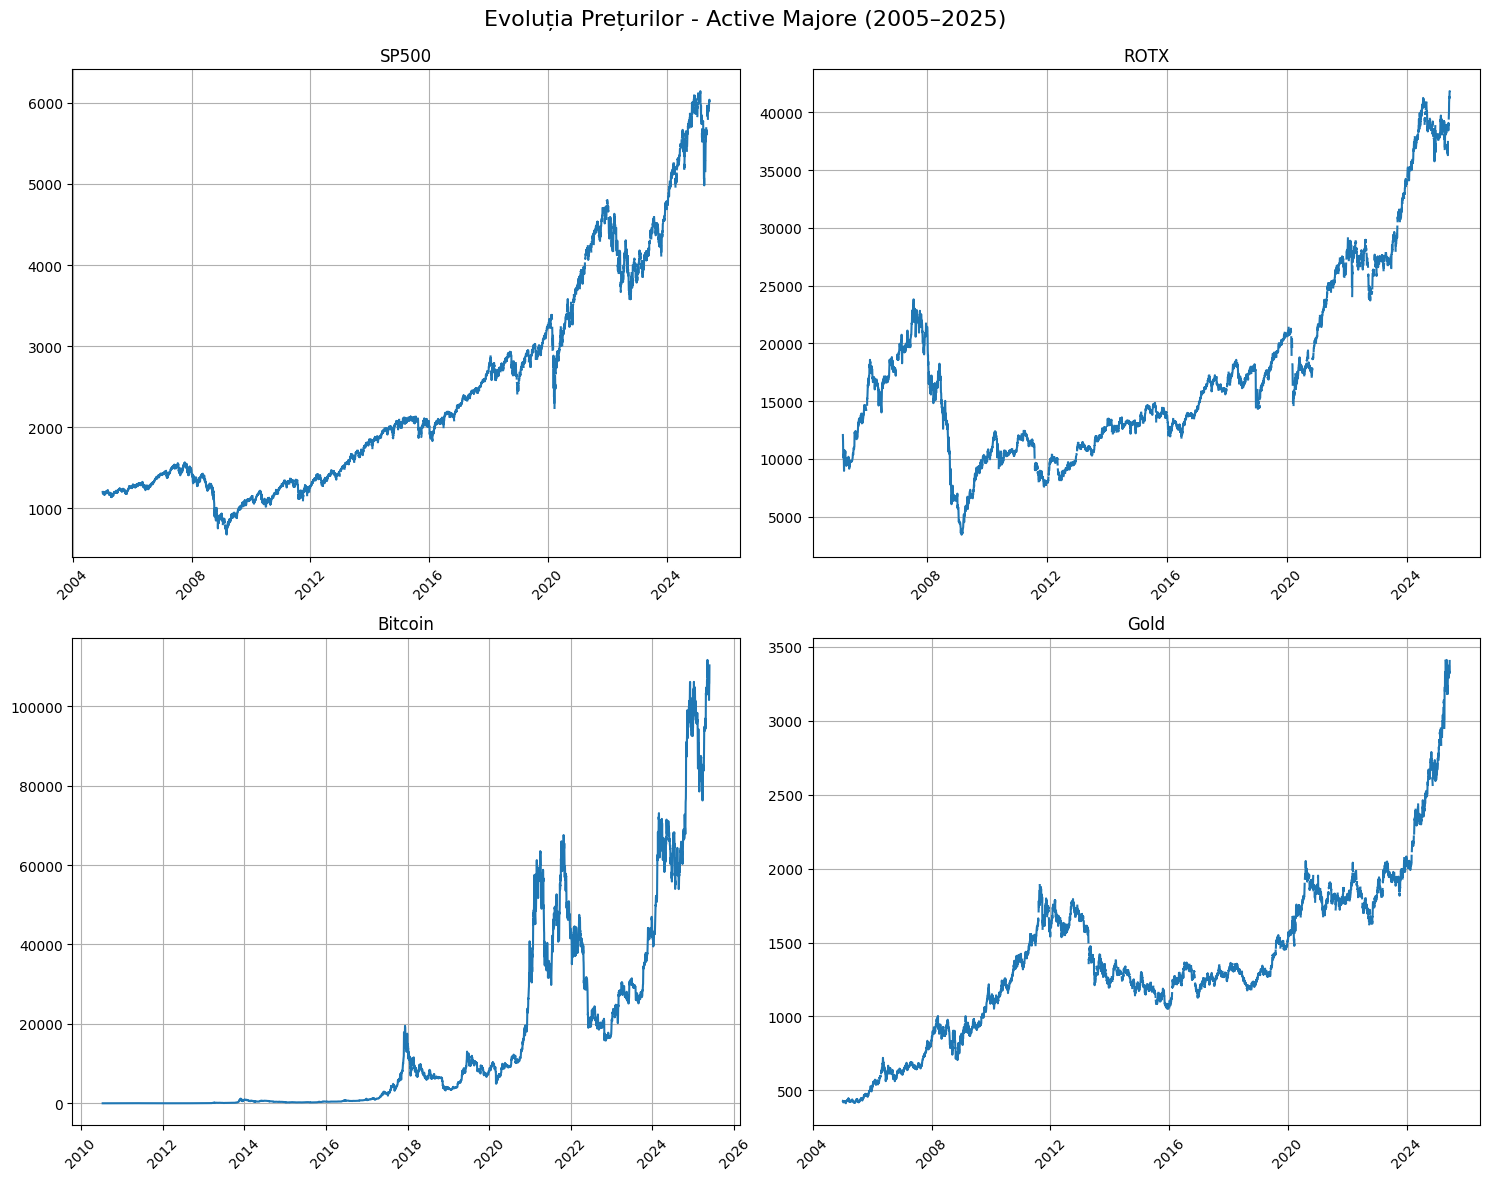

In [ ]:
import matplotlib.pyplot as plt

# Creez figura cu 3 rânduri și 2 coloane (ultimul subplot va rămâne gol)
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Evoluția Prețurilor - Active Majore (2005–2025)', fontsize=16)

# Așezăm activele în ordinea dorită: SP500, Gold, Bitcoin, ROTX, Oil
assets = ['SP500', 'ROTX', 'Bitcoin', 'Gold',]

# Flatten pentru accesare simplificată
axs = axs.flatten()

# Plot individual
for i, asset in enumerate(assets):
    axs[i].plot(real_prices_df.index, real_prices_df[asset])
    axs[i].set_title(asset)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

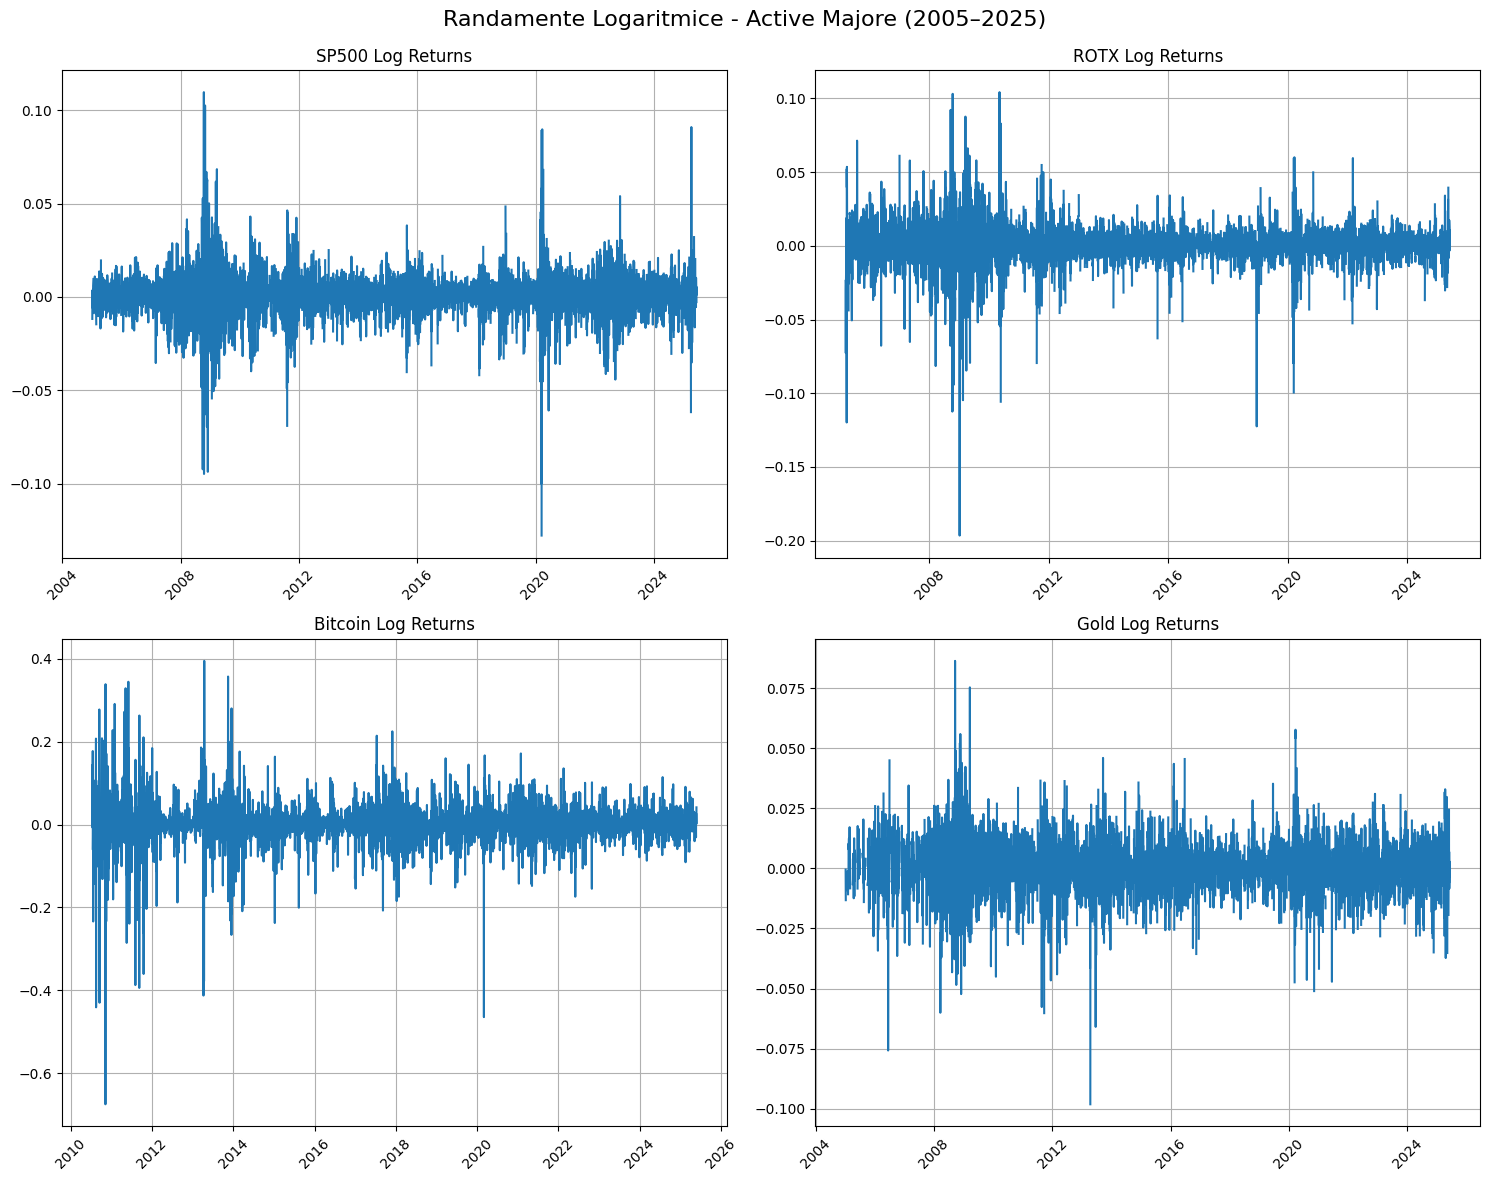

In [ ]:
import matplotlib.pyplot as plt

# Creez figura cu 2 rânduri și 2 coloane
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Randamente Logaritmice - Active Majore (2005–2025)', fontsize=16)

# Aleg activele (fără Oil)
assets = ['SP500', 'ROTX', 'Bitcoin', 'Gold']

# Flatten pentru acces simplu
axs = axs.flatten()

# Plot individual
for i, asset in enumerate(assets):
    axs[i].plot(log_real_prices_df.index, log_real_prices_df[asset])
    axs[i].set_title(f"{asset} Log Returns")
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


# **Individuale**

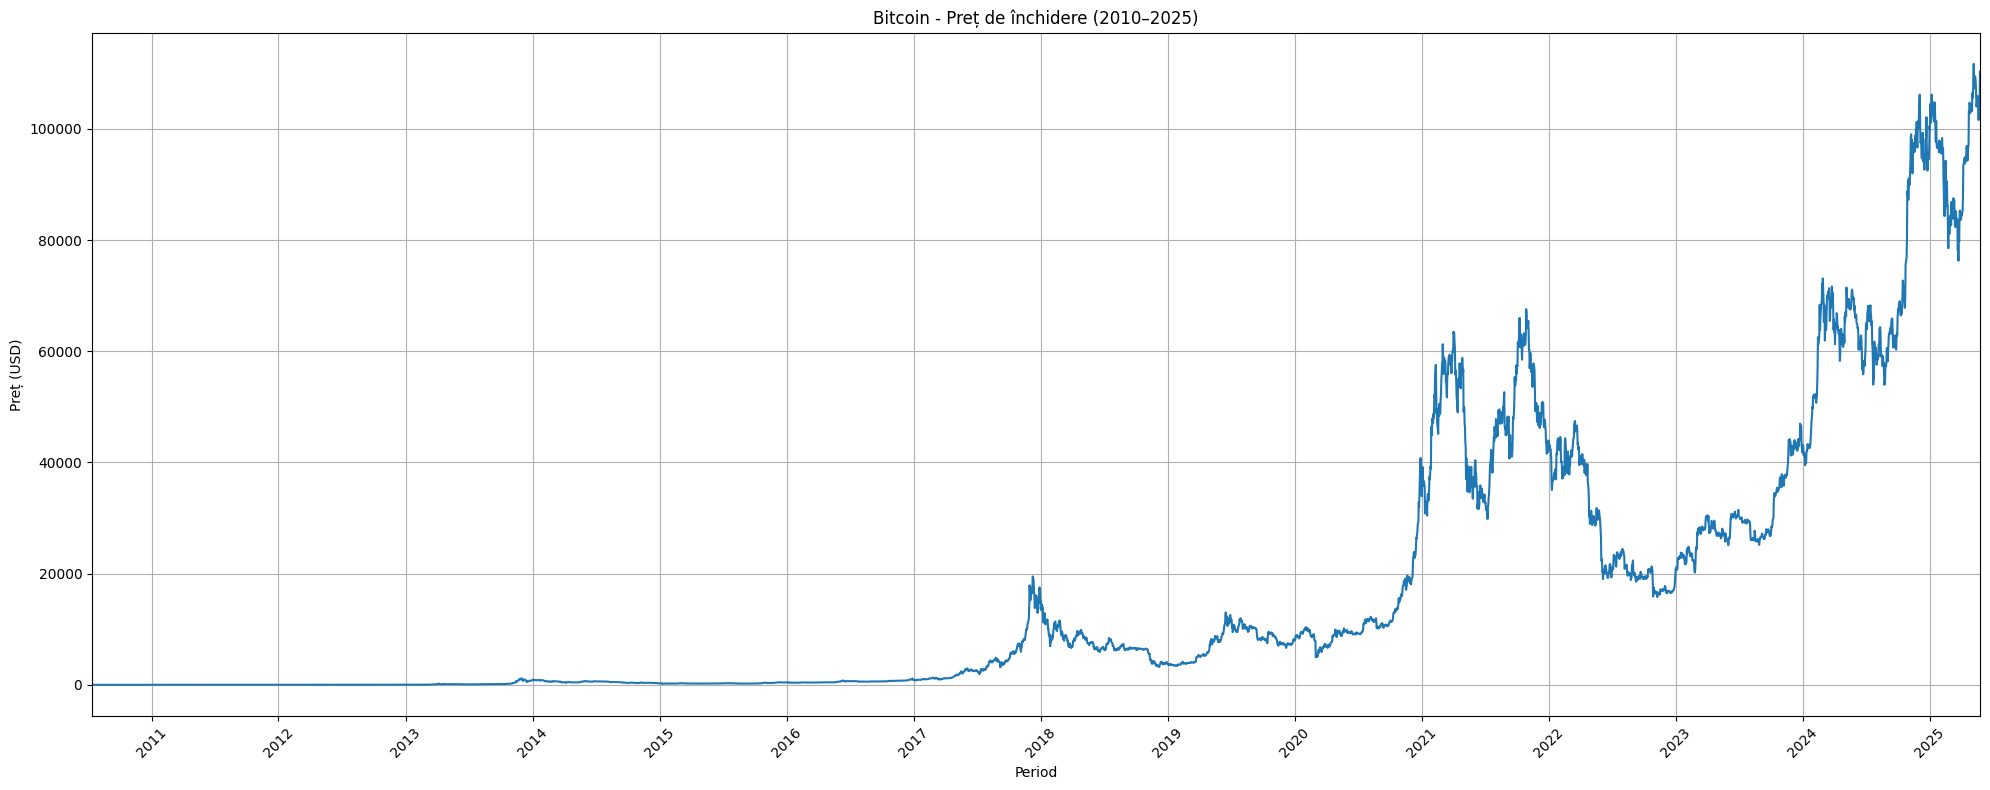

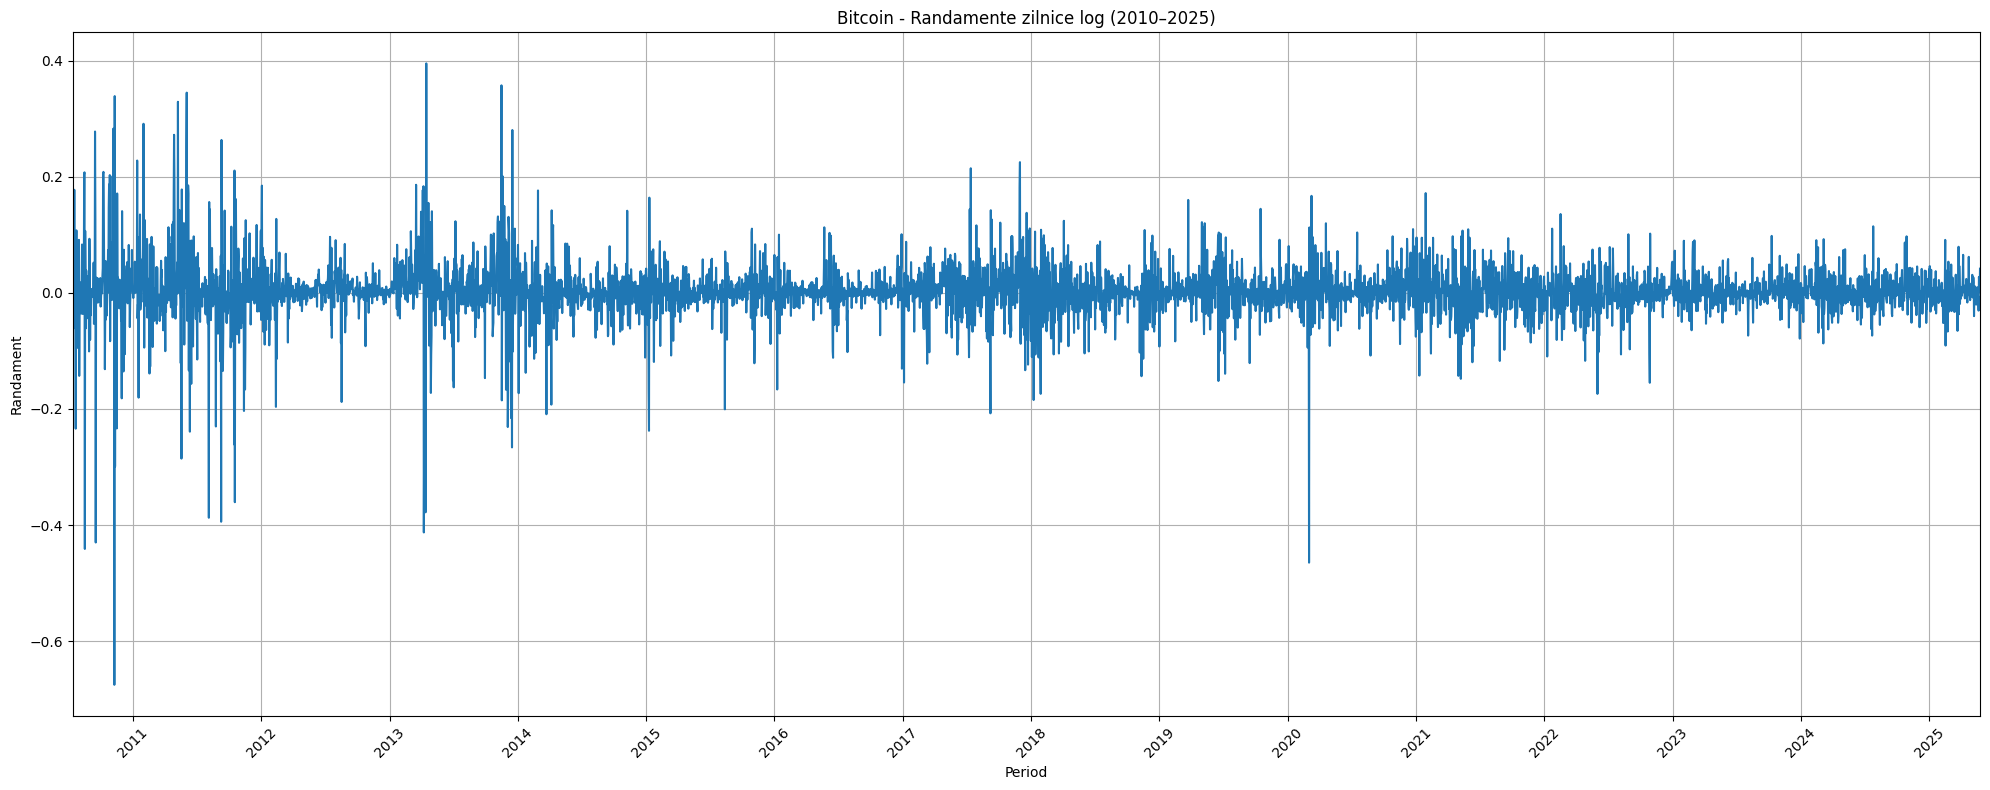

In [ ]:
#Bitcoin pret inchidere plot
fig, ax = plt.subplots(figsize=(20, 8))
bitcoin['Close'].plot(ax=ax, title='Bitcoin - Preț de închidere (2010–2025)', legend=False)
ax.set_ylabel("Preț (USD)")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()


#Bitcoin log randamente
fig, ax = plt.subplots(figsize=(20, 8))
bitcoin_log_returns['Close'].plot(ax=ax, title='Bitcoin - Randamente zilnice log (2010–2025)', legend=False)
ax.set_ylabel("Randament")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()

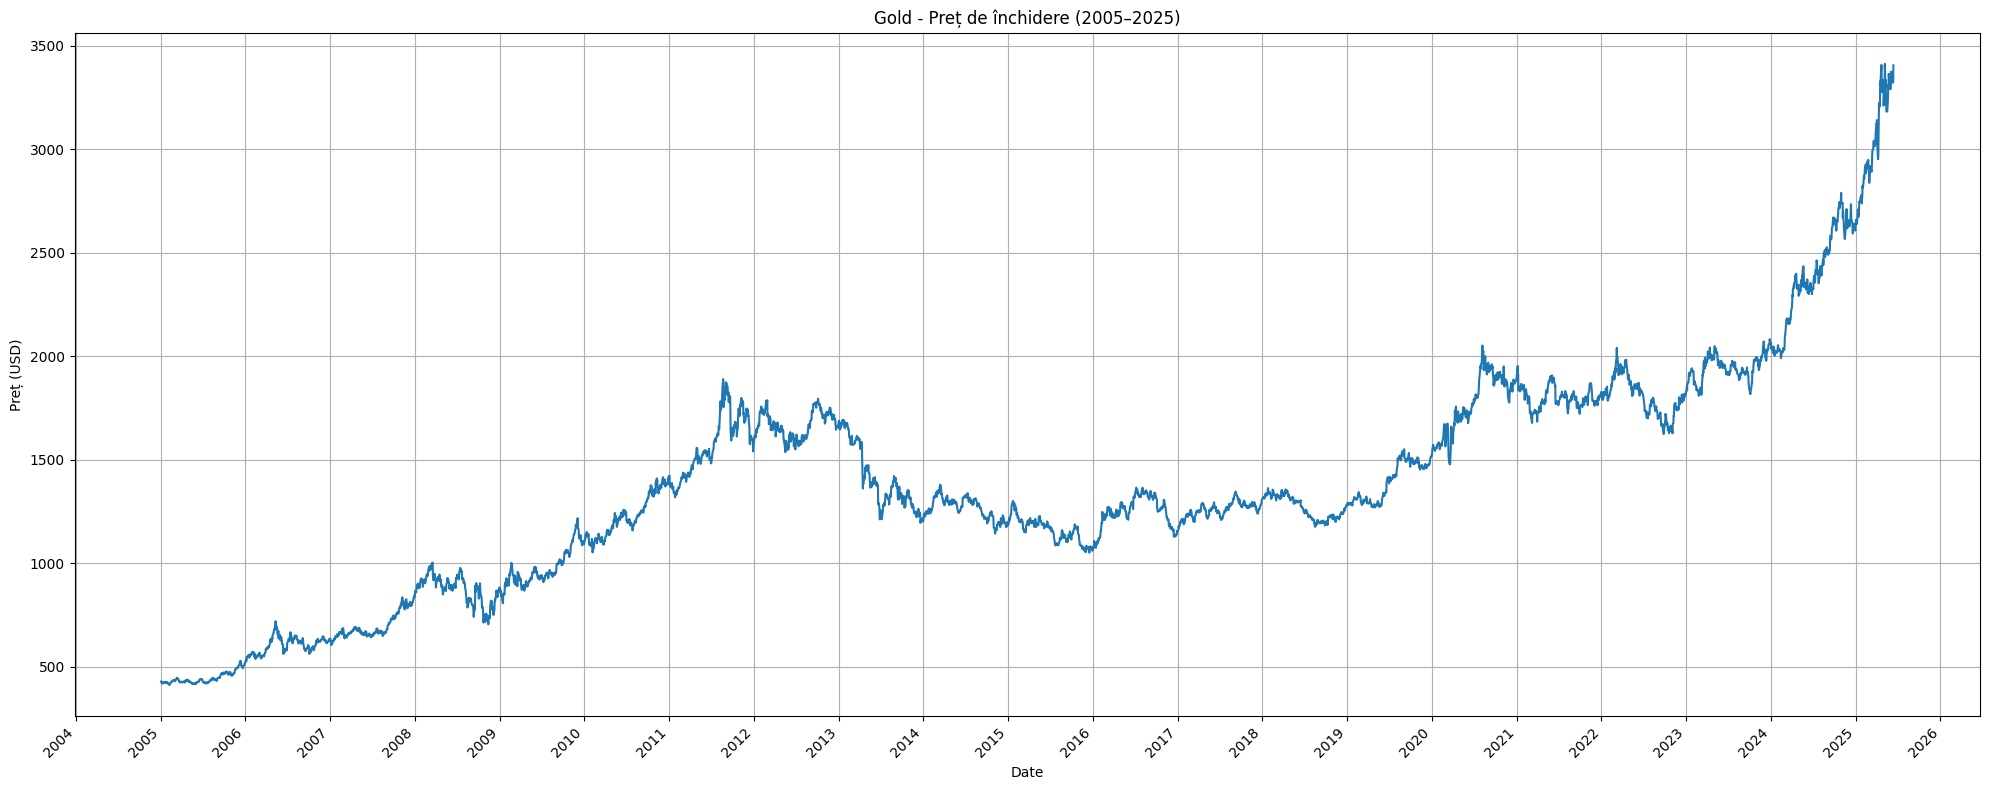

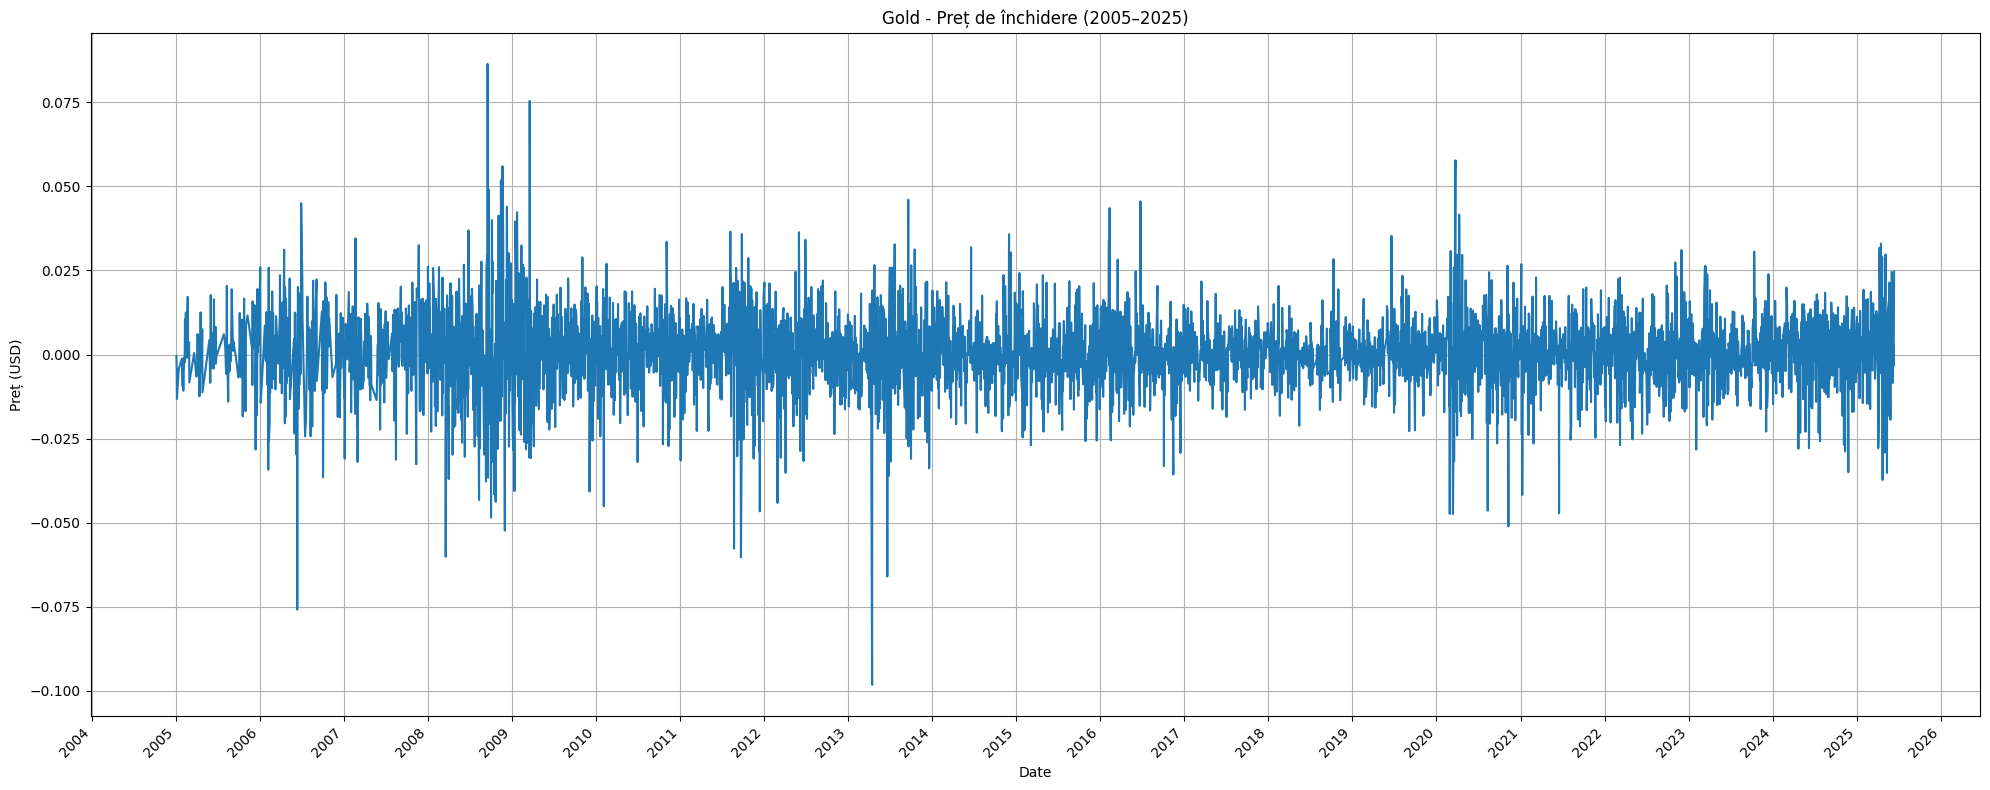

In [ ]:
#Gold plot
fig, ax = plt.subplots(figsize=(20, 8))
gold['Close'].plot(ax=ax, title='Gold - Preț de închidere (2005–2025)', legend=False)
ax.set_ylabel("Preț (USD)")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(20, 8))
gold_log_returns['Close'].plot(ax=ax, title='Gold - Preț de închidere (2005–2025)', legend=False)
ax.set_ylabel("Preț (USD)")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()

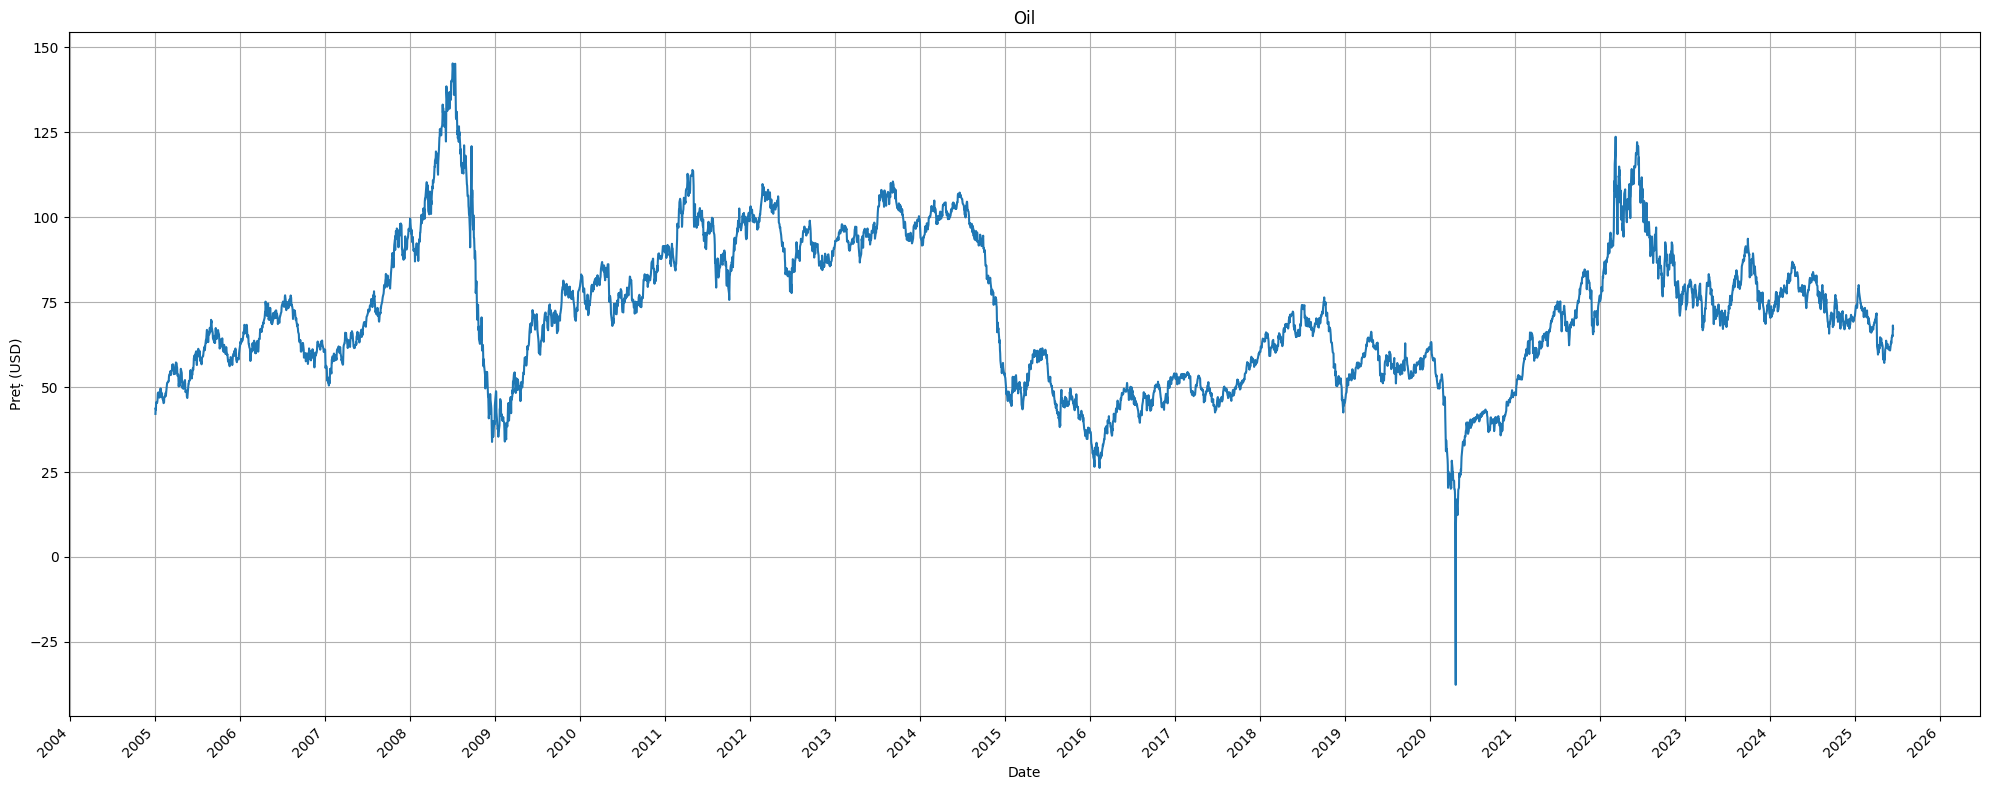

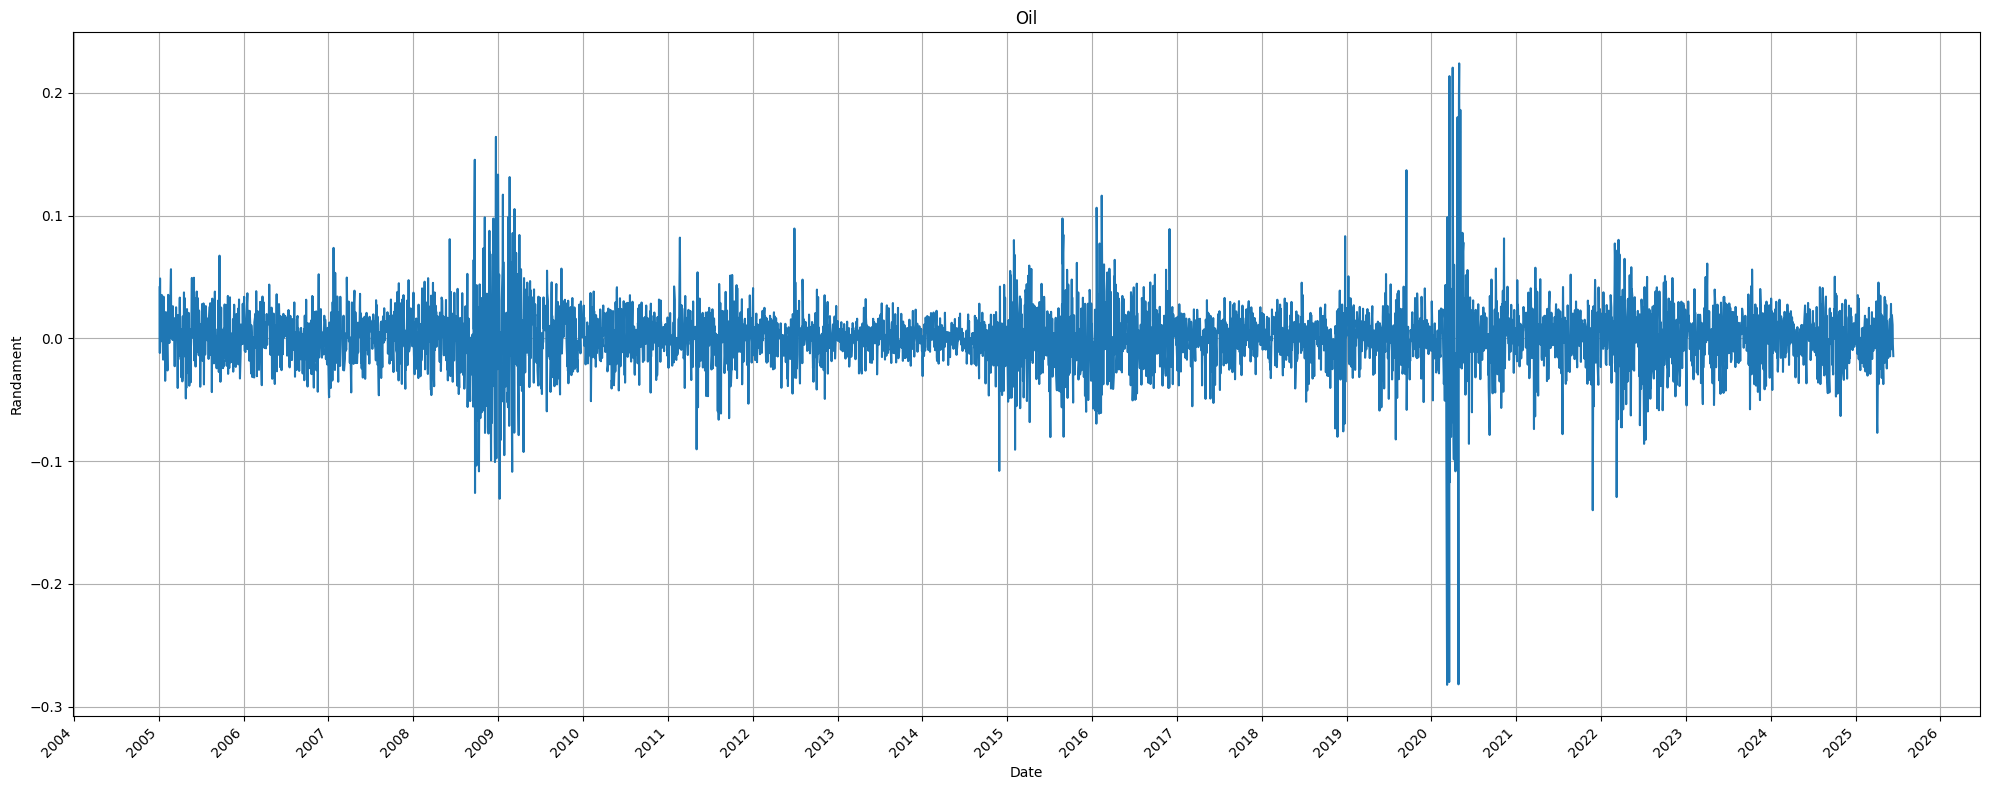

In [ ]:
#Oil plot
fig, ax = plt.subplots(figsize=(20, 8))
oil['Close'].plot(ax=ax, title='Oil', legend=False)
ax.set_ylabel("Preț (USD)")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()


#Oil log randamente
fig, ax = plt.subplots(figsize=(20, 8))
oil_log_returns['Close'].plot(ax=ax, title='Oil', legend=False)
ax.set_ylabel("Randament")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()

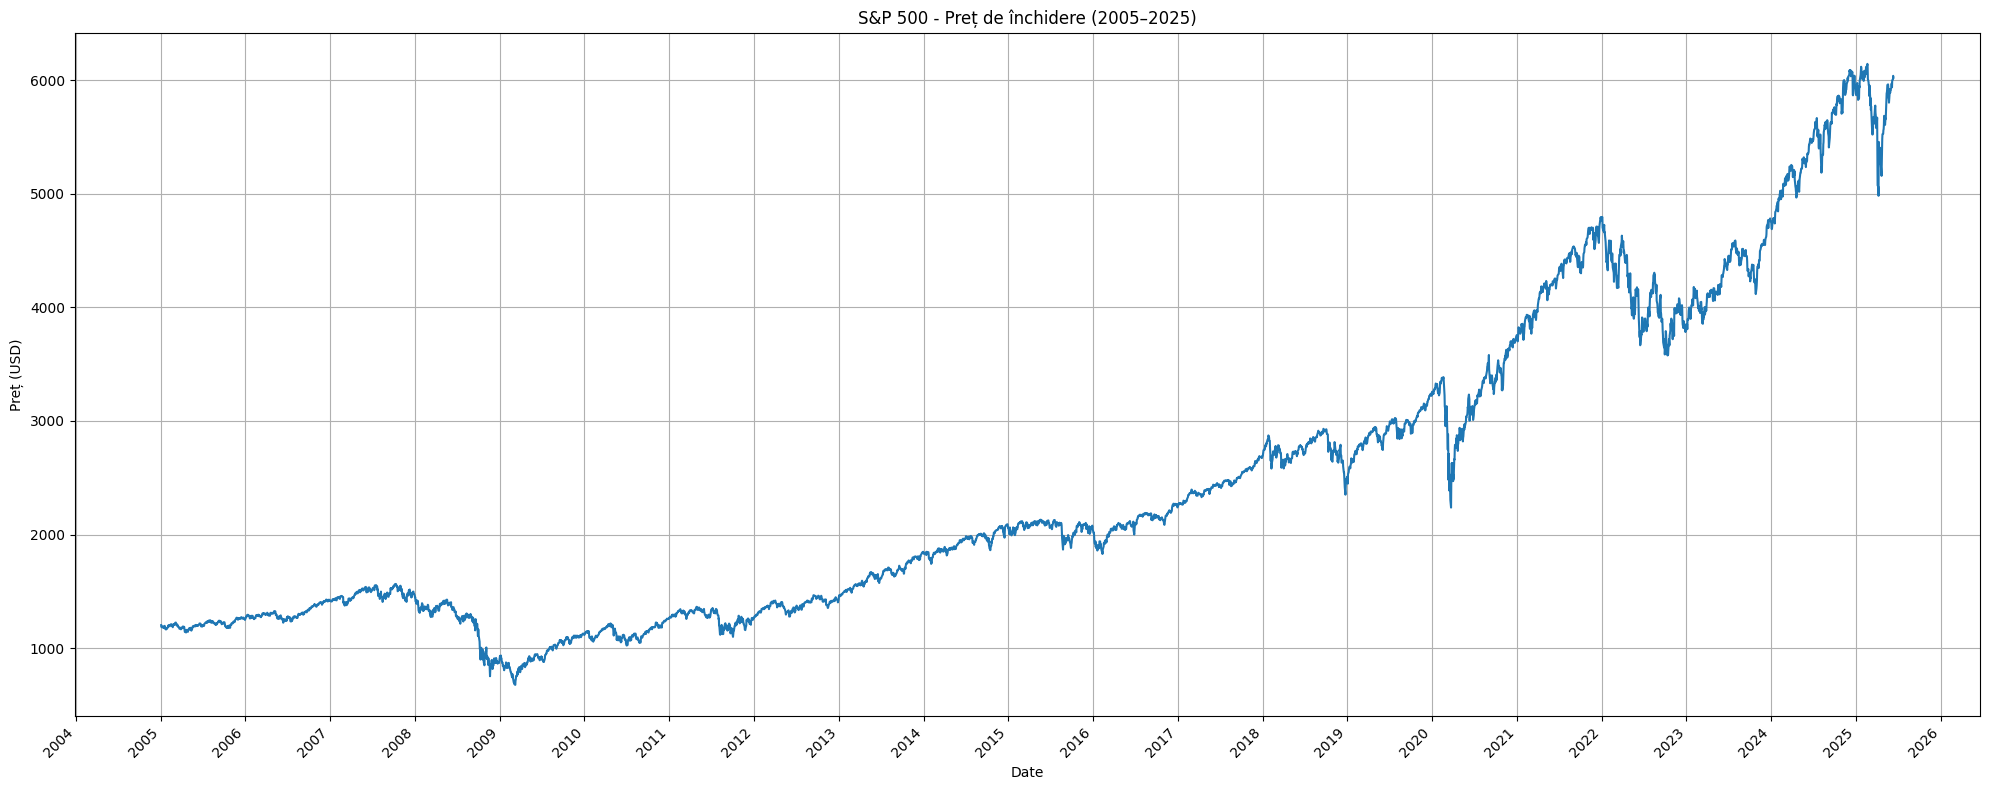

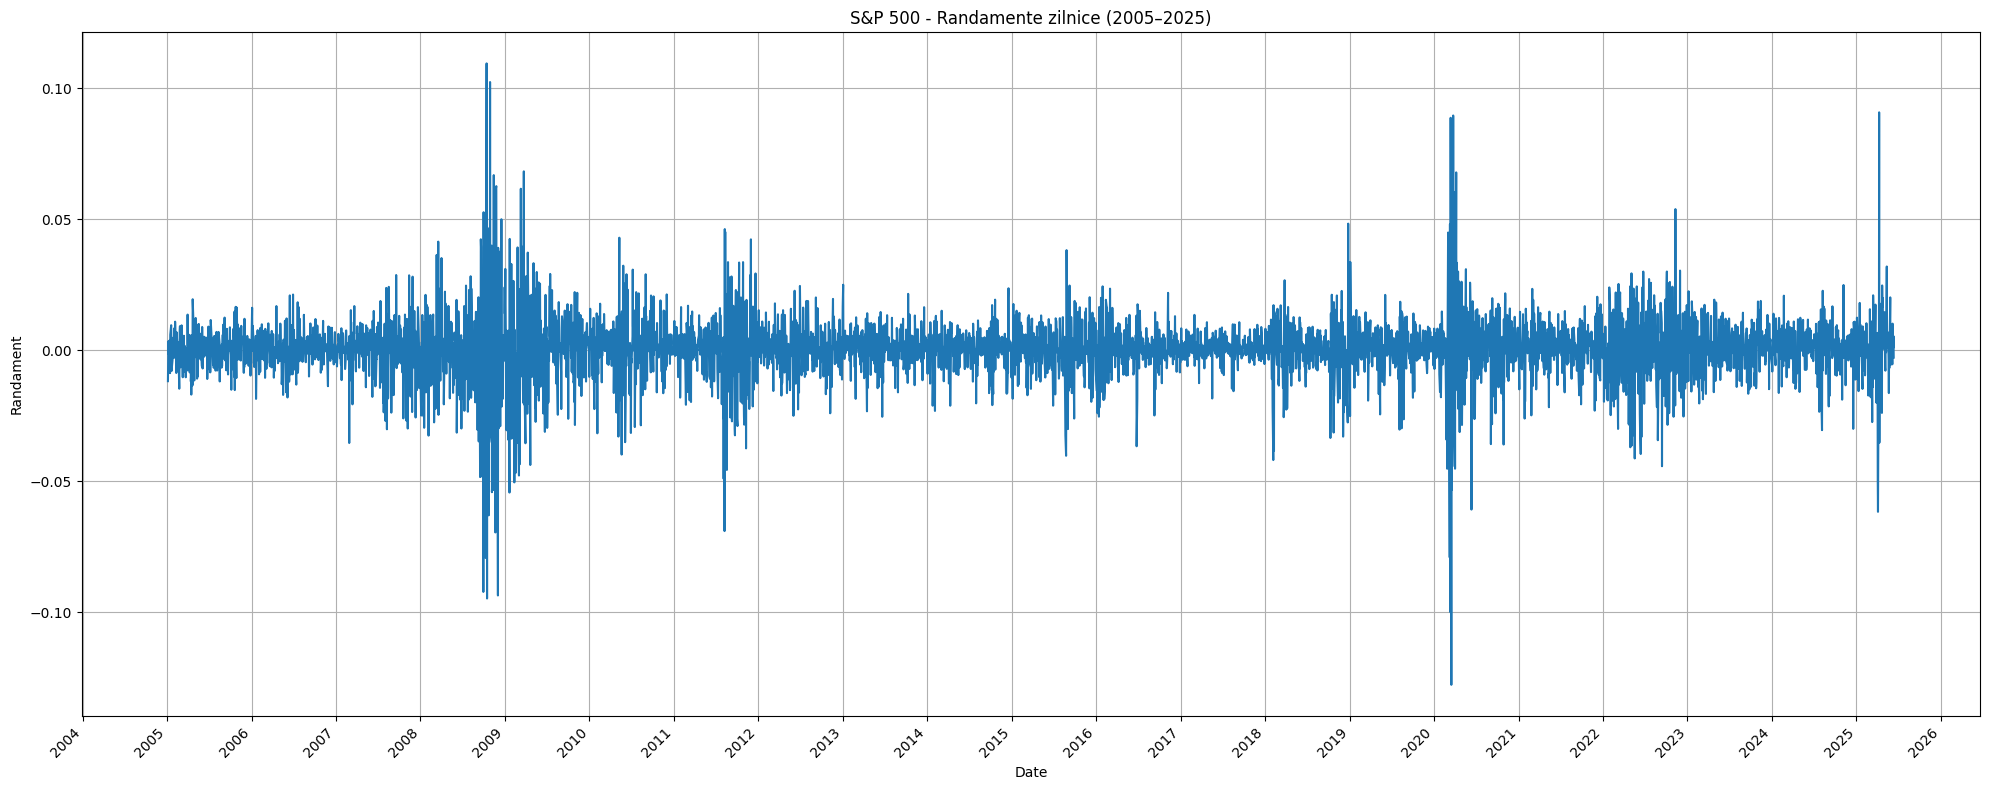

In [ ]:
import matplotlib.pyplot as plt

# === SP500: Preț de închidere ===
fig, ax = plt.subplots(figsize=(20, 8))
sp500['Close'].plot(ax=ax, title='S&P 500 - Preț de închidere (2005–2025)', legend=False)
ax.set_ylabel("Preț (USD)")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()

# === SP500: Randamente logaritmice ===
fig, ax = plt.subplots(figsize=(20, 8))
sp500_log_returns['Close'].plot(ax=ax, title='S&P 500 - Randamente zilnice (2005–2025)', legend=False)
ax.set_ylabel("Randament")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()

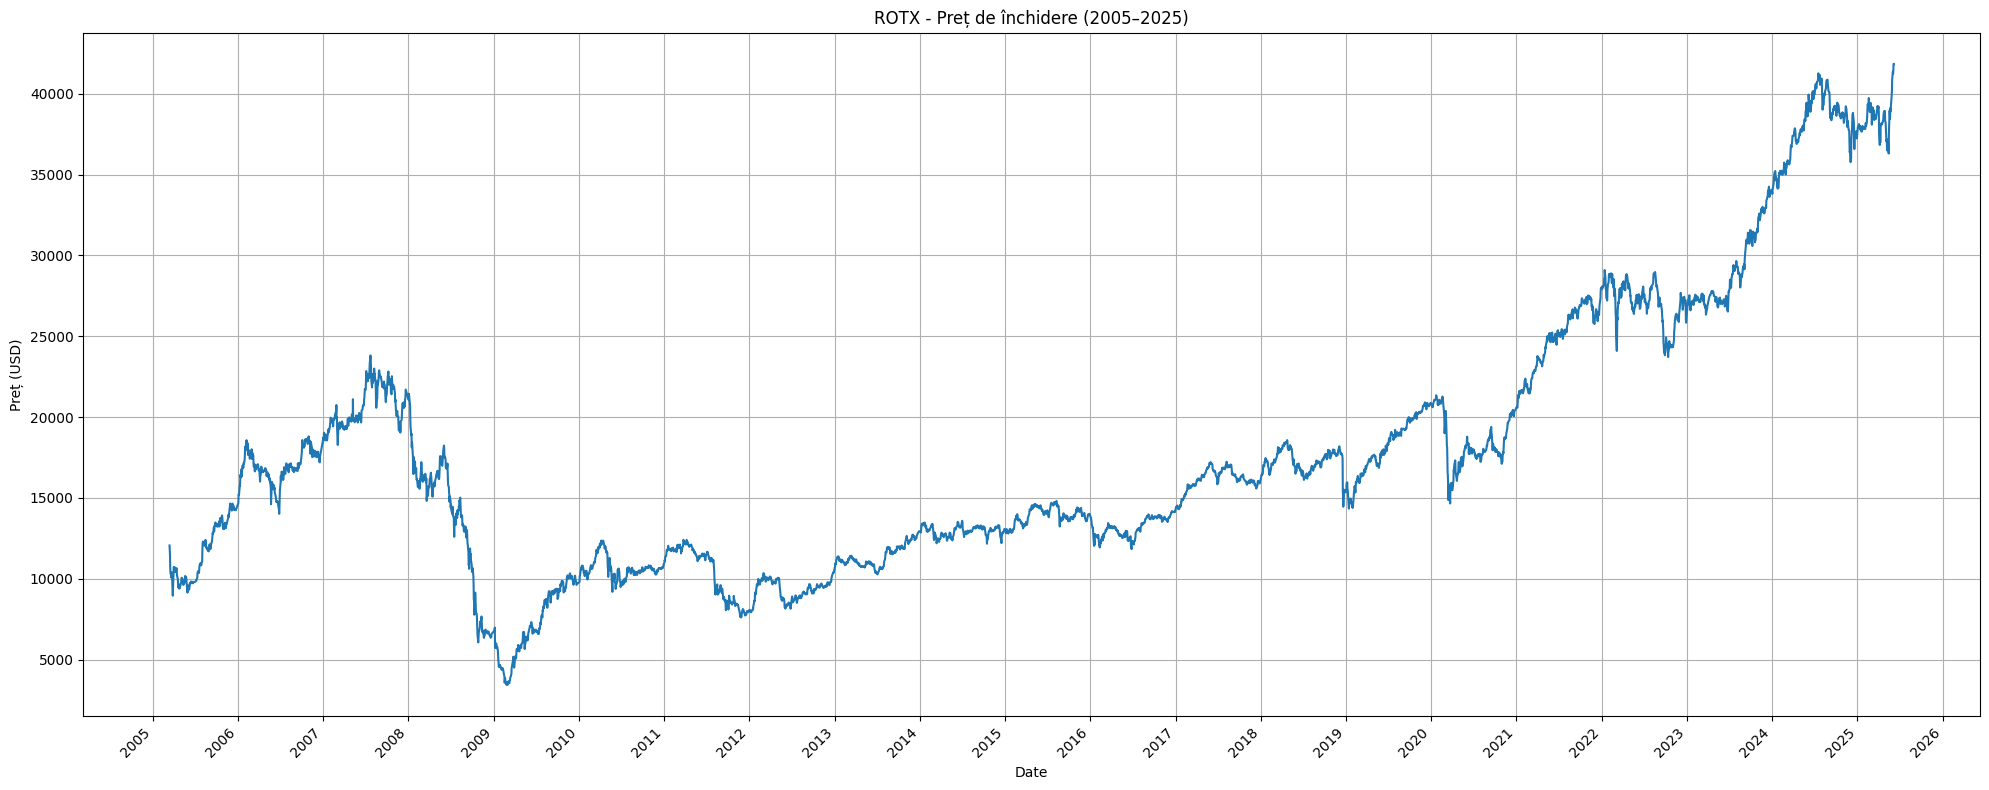

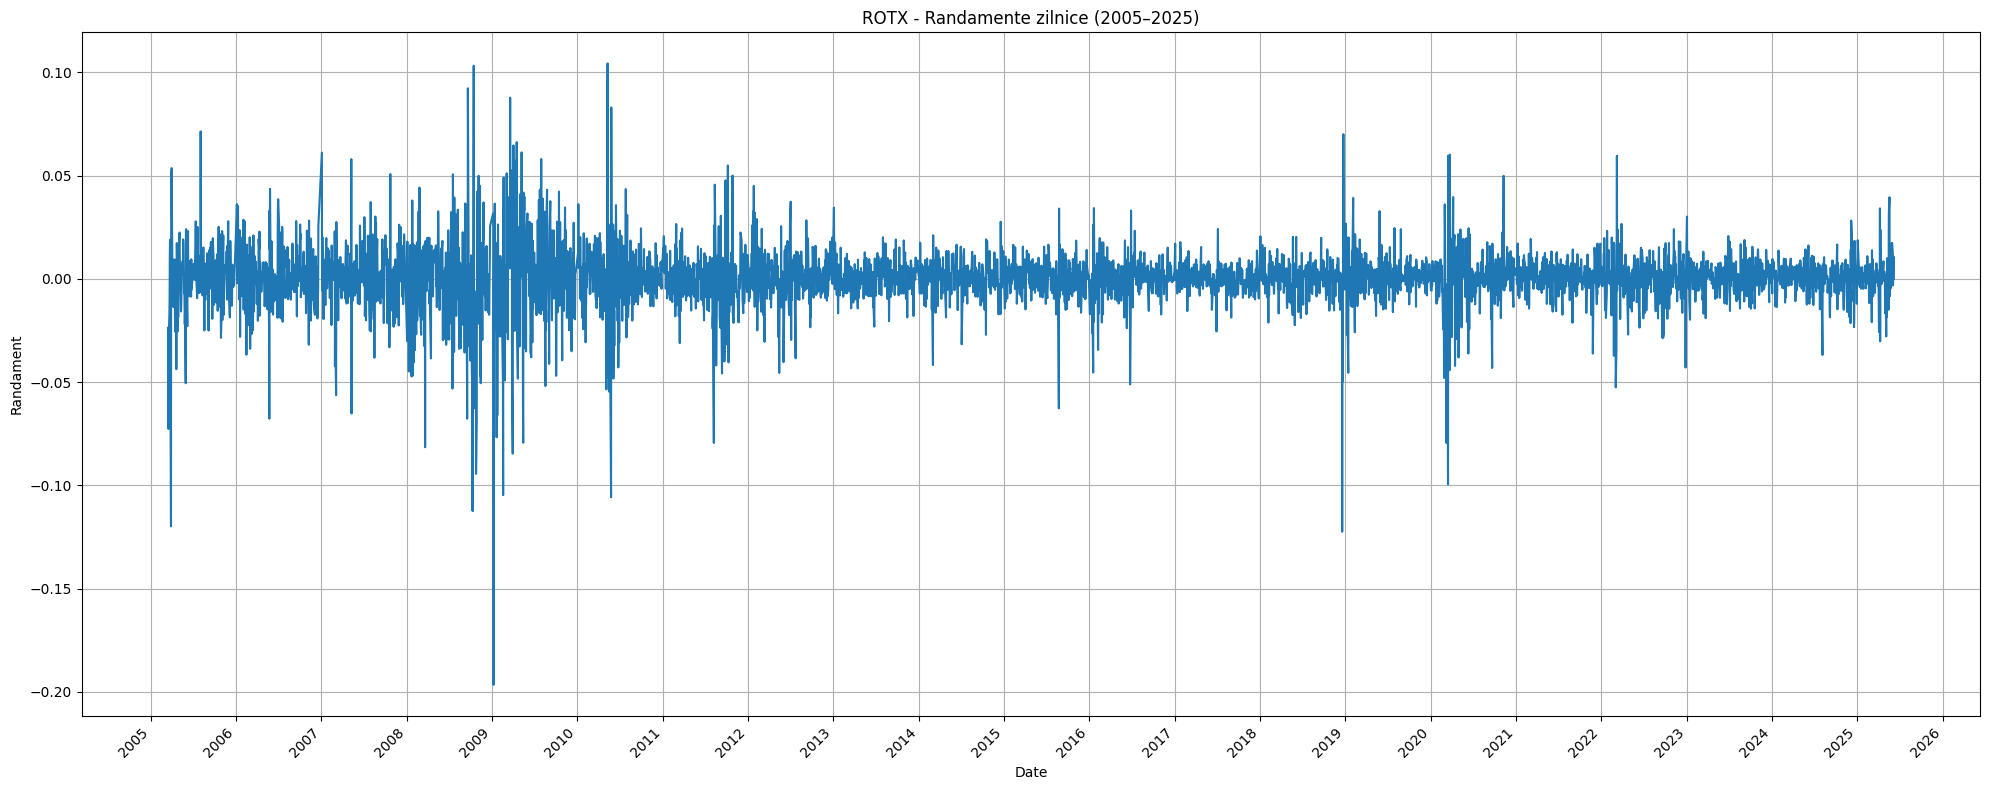

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === ROTX: Preț de închidere ===
plt.figure(figsize=(20, 8))
rotx['Close'].plot(title='ROTX - Preț de închidere (2005–2025)')
plt.ylabel("Preț (USD)")
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # un marcaj pe an
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

# === ROTX: Randamente zilnice ===
plt.figure(figsize=(20, 8))
rotx_log_returns['Close'].plot(title='ROTX - Randamente zilnice (2005–2025)')
plt.ylabel("Randament")
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

# **ADF/KPSS/PP**

In [ ]:
def analiza_trend(series, title=''):
    print(f'=== Analiza trend pentru {title} ===\n')

    # 2. Test ADF
    adf = ADF(series, trend='ct')
    print(adf.summary(),'\n')
    adf_stationary = adf.pvalue < 0.05

    # 3. Test KPSS
    kpss_test = KPSS(series, trend='ct')
    print(kpss_test.summary(),'\n')
    kpss_stationary = kpss_test.pvalue > 0.05

    # 4. Test Phillips-Perron
    pp = PhillipsPerron(series, trend='ct')
    print(pp.summary(),'\n')
    pp_stationary = pp.pvalue < 0.05

    # 5. Concluzie automată
    print('--- Concluzie ---')
    if adf_stationary and pp_stationary and kpss_stationary:
        print(f'Seria {title} are un trend determinist.')
    elif not adf_stationary and not pp_stationary and not kpss_stationary:
        print(f'Seria {title} are un trend stochastic.')
    else:
        print(f'Seria {title} necesită o analiză mai detaliată (rezultate mixte între teste).')
    print('=============================\n')

analiza_trend(sp500['Close'], title='S&P 500 - Close')
analiza_trend(sp500_log_returns['Close'], title='S&P 500 - Close')

=== Analiza trend pentru S&P 500 - Close ===

   Augmented Dickey-Fuller Results   
Test Statistic                 -0.995
P-value                         0.945
Lags                               30
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

    KPSS Stationarity Test Results   
Test Statistic                  2.252
P-value                         0.000
Lags                               43
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root. 

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.143
P-value                         0.922
Lags                               33
-------------------

In [ ]:
import pandas as pd
from arch.unitroot import ADF, KPSS, PhillipsPerron

def analiza_trend_multi_verdict(df, trends=['c', 'ct']):
    rezultate = []

    for col in df.columns:
        serie = df[col].dropna()

        for trend in trends:
            adf = ADF(serie, trend=trend)
            pp = PhillipsPerron(serie, trend=trend)

            # KPSS acceptă doar 'c' și 'ct'
            kpss_test = KPSS(serie, trend=trend)

            adf_stationary = adf.pvalue < 0.05
            pp_stationary = pp.pvalue < 0.05
            kpss_stationary = kpss_test.pvalue > 0.05

            if adf_stationary and pp_stationary and kpss_stationary:
                verdict = 'Staționară'
            elif not adf_stationary and not pp_stationary and not kpss_stationary:
                verdict = 'Trend stochastic'
            else:
                verdict = 'Mix / incert'

            rezultate.append({
                'Serie': col,
                'Trend': trend,
                'ADF p-value': adf.pvalue,
                'PP p-value': pp.pvalue,
                'KPSS p-value': kpss_test.pvalue,
                'Verdict': verdict
            })

    tabel_verdict = pd.DataFrame(rezultate)
    tabel_verdict.index += 1
    return tabel_verdict


rezultate_finale = analiza_trend_multi_verdict(real_prices_df)
rezultate_finale.head(20)

,Serie,Trend,ADF p-value,PP p-value,KPSS p-value,Verdict
1,SP500,c,0.998085,0.997631,0.000100,Trend stochastic
2,SP500,ct,0.946583,0.924452,0.000100,Trend stochastic
3,Gold,c,0.998625,0.998692,0.000100,Trend stochastic
4,Gold,ct,1.000000,1.000000,0.000100,Trend stochastic
5,Oil,c,0.016566,0.027235,0.002433,Mix / incert
6,Oil,ct,0.059267,0.089096,0.000100,Trend stochastic
7,Bitcoin,c,0.988108,0.996678,0.000100,Trend stochastic
8,Bitcoin,ct,0.923489,0.984478,0.000100,Trend stochastic
9,ROTX,c,0.994356,0.994380,0.000100,Trend stochastic
10,ROTX,ct,0.983316,0.981063,0.000100,Trend stochastic


In [ ]:
rezultate_finale = analiza_trend_multi_verdict(log_real_prices_df)
rezultate_finale.head(20)

,Serie,Trend,ADF p-value,PP p-value,KPSS p-value,Verdict
1,SP500,c,5.671887e-29,0.0,0.332749,Staționară
2,SP500,ct,1.114727e-22,0.0,0.727923,Staționară
3,Gold,c,0.000000e+00,0.0,0.401852,Staționară
4,Gold,ct,0.000000e+00,0.0,0.053158,Staționară
5,Oil,c,7.714496e-23,0.0,0.852185,Staționară
6,Oil,ct,1.320620e-19,0.0,0.634947,Staționară
7,Bitcoin,c,4.298329e-20,0.0,0.017850,Mix / incert
8,Bitcoin,ct,8.045018e-18,0.0,0.152165,Staționară
9,ROTX,c,1.147040e-20,0.0,0.301188,Staționară
10,ROTX,ct,5.295654e-18,0.0,0.595757,Staționară


In [ ]:
analiza_trend(rotx['Close'], title='ROTX - Close')
analiza_trend(rotx_log_returns['Close'], title='ROTX - Close')

=== Analiza trend pentru ROTX - Close ===

   Augmented Dickey-Fuller Results   
Test Statistic                 -0.503
P-value                         0.983
Lags                                2
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

    KPSS Stationarity Test Results   
Test Statistic                  2.135
P-value                         0.000
Lags                               42
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root. 

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.556
P-value                         0.981
Lags                               32
----------------------

In [ ]:
analiza_trend(gold['Close'], title='GOLD - Close')
analiza_trend(gold_log_returns['Close'], title='GOLD - Close')

=== Analiza trend pentru GOLD - Close ===

   Augmented Dickey-Fuller Results   
Test Statistic                  0.850
P-value                         1.000
Lags                               31
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

    KPSS Stationarity Test Results   
Test Statistic                  1.040
P-value                         0.000
Lags                               43
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root. 

     Phillips-Perron Test (Z-tau)    
Test Statistic                  0.819
P-value                         1.000
Lags                               33
----------------------

In [ ]:
analiza_trend(oil['Close'], title='OIL - Close')
analiza_trend(oil_log_returns['Close'], title='OIL - Close')

=== Analiza trend pentru OIL - Close ===

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.343
P-value                         0.059
Lags                               29
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

    KPSS Stationarity Test Results   
Test Statistic                  0.642
P-value                         0.000
Lags                               43
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root. 

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.176
P-value                         0.089
Lags                               33
-----------------------

In [ ]:
analiza_trend(bitcoin['Close'], title='BITCOIN - Close')
analiza_trend(bitcoin_log_returns['Close'], title='BITCOIN - Close')

=== Analiza trend pentru BITCOIN - Close ===

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.132
P-value                         0.923
Lags                               31
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

    KPSS Stationarity Test Results   
Test Statistic                  1.496
P-value                         0.000
Lags                               43
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root. 

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.472
P-value                         0.984
Lags                               33
-------------------

# **ACF/PACF**

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=20, title_prefix=''):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    plot_acf(series, lags=lags, ax=axes[0], markersize=4)
    axes[0].set_title(f'ACF - {title_prefix}')

    plot_pacf(series, lags=lags, ax=axes[1], markersize=4)
    axes[1].set_title(f'PACF - {title_prefix}')

    plt.tight_layout()
    plt.show()


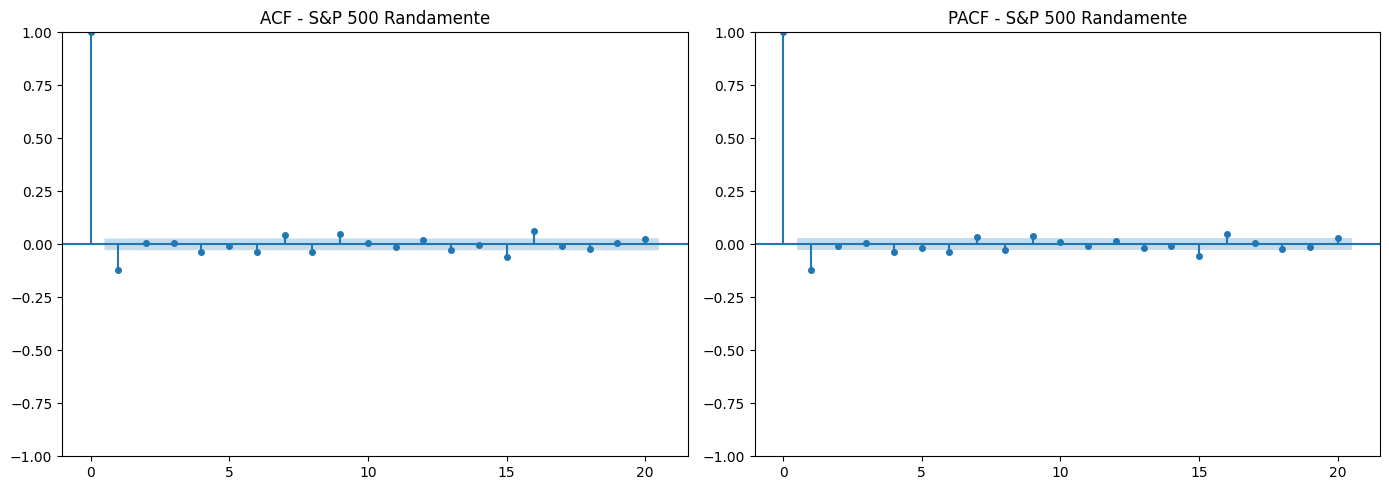

In [ ]:
plot_acf_pacf(sp500_log_returns['Close'], lags=20, title_prefix='S&P 500 Randamente')

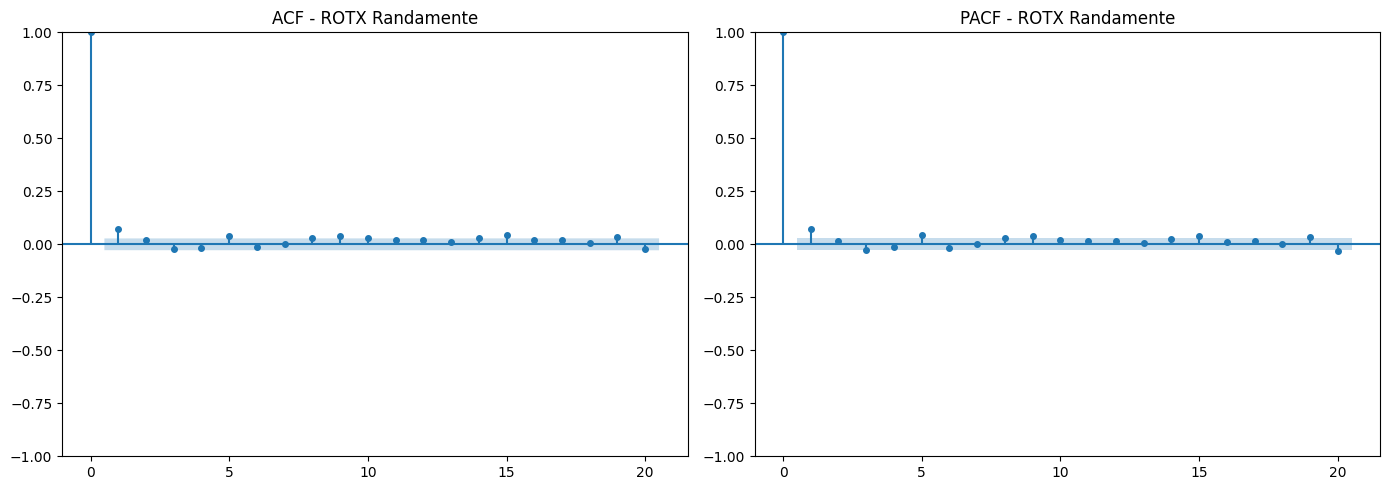

In [ ]:
plot_acf_pacf(rotx_log_returns['Close'], lags=20, title_prefix='ROTX Randamente')

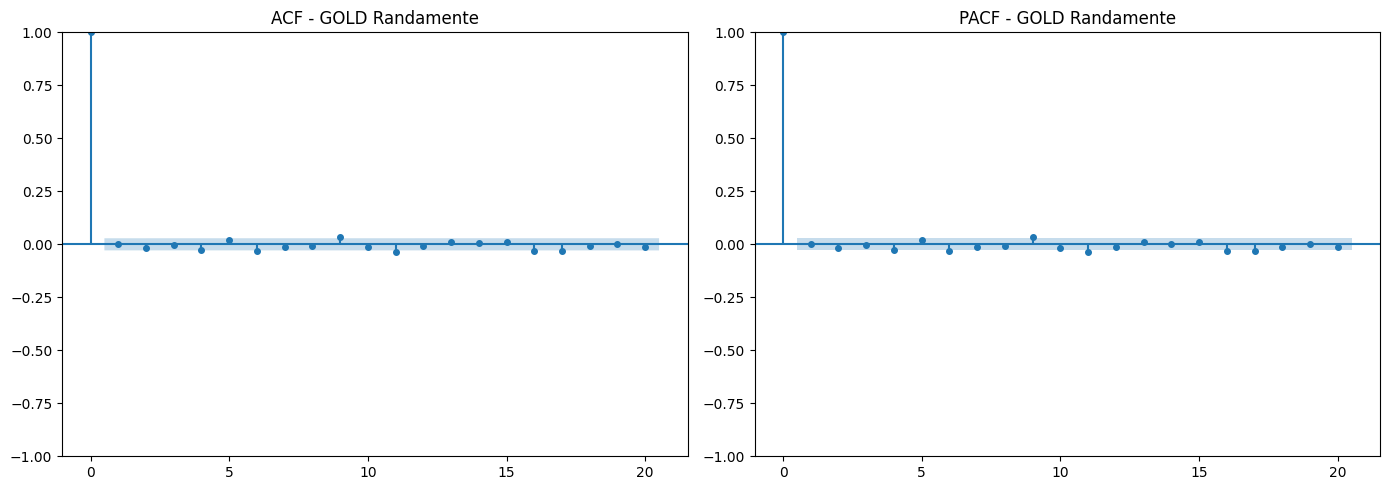

In [ ]:
plot_acf_pacf(gold_log_returns['Close'], lags=20, title_prefix='GOLD Randamente')

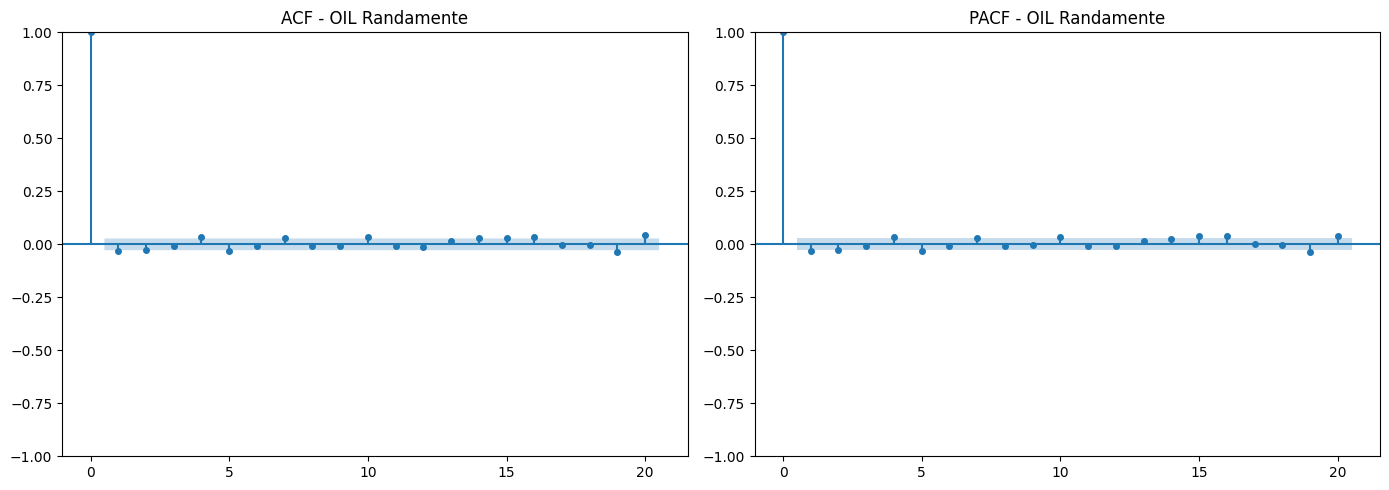

In [ ]:
plot_acf_pacf(oil_log_returns['Close'], lags=20, title_prefix='OIL Randamente')

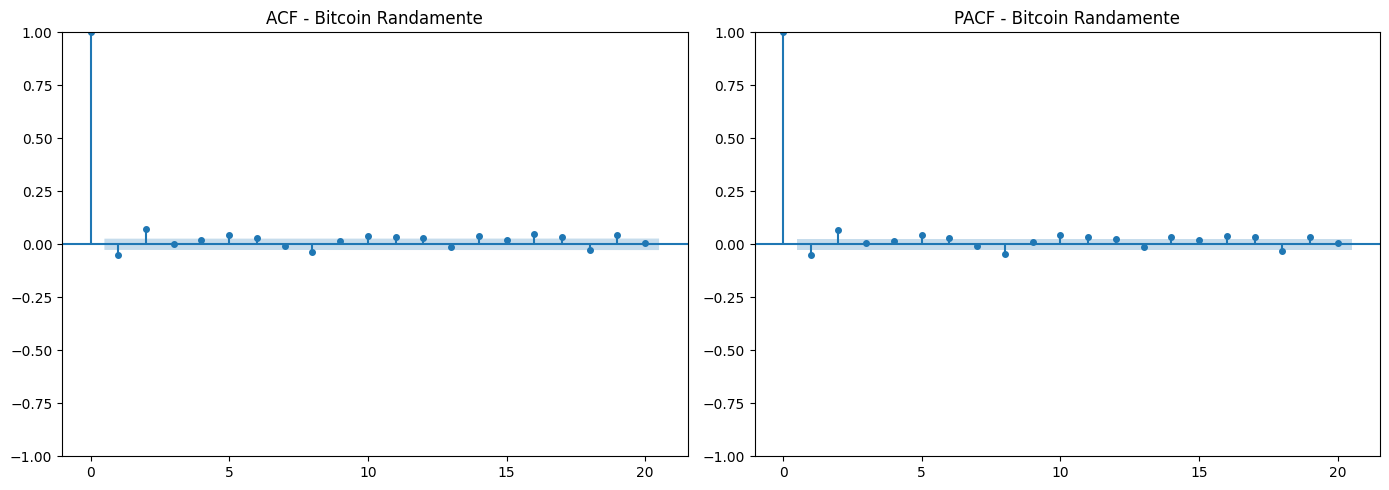

In [ ]:
plot_acf_pacf(bitcoin_log_returns['Close'], lags=20, title_prefix='Bitcoin Randamente')

# **MODELE ARMA/ARIMA**

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import kurtosis, skew
import numpy as np
import pandas as pd
import warnings

def testeaza_modele_arima(serie, p_max=3, d=0, q_max=3, alpha=0.05):
    rezultate = []

    for p in range(p_max + 1):
        for q in range(q_max + 1):
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")

                    model = ARIMA(serie, order=(p, d, q))
                    fitted = model.fit()
                    resid = fitted.resid.dropna()

                    p_values = fitted.pvalues
                    nr_semnificativi = (p_values < alpha).sum()

                    rezultate.append({
                        'Model': f'ARIMA({p},{d},{q})',
                        'AIC': fitted.aic,
                        'BIC': fitted.bic,
                        'HQIC': fitted.hqic,
                        'LogLik': fitted.llf,
                        'Num_Params': len(fitted.params),
                        'Coef_Signif': nr_semnificativi,
                        'Sigma2': np.var(resid, ddof=1),
                        'Skewness': skew(resid),
                        'Kurtosis': kurtosis(resid),
                    })

            except Exception:
                continue

    df_rezultate = pd.DataFrame(rezultate)

    # Adăugăm coloana All_Significant
    df_rezultate['All_Significant'] = df_rezultate['Coef_Signif'] == df_rezultate['Num_Params']

    # Sortăm: întâi toate modelele complet semnificative, apoi după AIC
    df_rezultate = df_rezultate.sort_values(by=['All_Significant', 'AIC'], ascending=[False, True]).reset_index(drop=True)

    return df_rezultate


testeaza_modele_arima(sp500_log_returns['Close'])

,Model,AIC,BIC,HQIC,LogLik,Num_Params,Coef_Signif,Sigma2,Skewness,Kurtosis,All_Significant
0,"ARIMA(2,0,1)",-30576.220693,-30543.526898,-30564.774536,15293.110346,5,5,0.000147,-0.632146,12.173521,True
1,"ARIMA(0,0,1)",-30575.832710,-30556.216433,-30568.965016,15290.916355,3,3,0.000147,-0.640434,12.239181,True
2,"ARIMA(1,0,0)",-30575.633003,-30556.016726,-30568.765309,15290.816502,3,3,0.000147,-0.620005,12.301743,True
3,"ARIMA(2,0,0)",-30574.050875,-30547.895839,-30564.893950,15291.025438,4,3,0.000147,-0.631499,12.255814,False
4,"ARIMA(1,0,1)",-30574.018339,-30547.863303,-30564.861413,15291.009169,4,2,0.000147,-0.631604,12.260915,False
5,"ARIMA(0,0,2)",-30574.009481,-30547.854445,-30564.852556,15291.004741,4,3,0.000147,-0.633343,12.253797,False
6,"ARIMA(3,0,0)",-30572.326189,-30539.632394,-30560.880032,15291.163095,5,2,0.000147,-0.620692,12.230281,False
7,"ARIMA(1,0,2)",-30572.009516,-30539.315721,-30560.563359,15291.004758,5,1,0.000147,-0.633346,12.253803,False
8,"ARIMA(0,0,3)",-30571.733425,-30539.039630,-30560.287268,15290.866712,5,2,0.000147,-0.622527,12.240924,False
9,"ARIMA(3,0,3)",-30570.748455,-30518.438383,-30552.434604,15293.374227,8,3,0.000147,-0.682314,12.131816,False


In [13]:
best_model_sp500_arima = ARIMA(sp500_log_returns['Close'], order=(2, 0, 1))
best_fitted_sp500 = best_model_sp500_arima.fit()
print(best_fitted_sp500.summary())

r_sp500 = best_fitted_sp500.resid
rsq_sp500 = r_sp500**2
rsq_sp500.head()

                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 5109
Model:                 ARIMA(2, 0, 1)   Log Likelihood               15293.110
Date:                Sat, 14 Jun 2025   AIC                         -30576.221
Time:                        14:03:51   BIC                         -30543.527
Sample:                             0   HQIC                        -30564.775
                               - 5109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      2.017      0.044    8.95e-06       0.001
ar.L1         -0.9330      0.138     -6.757      0.000      -1.204      -0.662
ar.L2         -0.1066      0.014     -7.367      0.0

,0
Date,
2005-01-04,0.000145
2005-01-05,0.000029
2005-01-06,0.000007
2005-01-07,0.000002
2005-01-10,0.000008


In [ ]:
testeaza_modele_arima(rotx_log_returns['Close'])

,Model,AIC,BIC,HQIC,LogLik,Num_Params,Coef_Signif,Sigma2,Skewness,Kurtosis,All_Significant
0,"ARIMA(3,0,3)",-28155.876511,-28103.726175,-28137.600118,14085.938255,8,7,0.000211,-1.178737,16.445148,False
1,"ARIMA(2,0,2)",-28154.077945,-28114.965194,-28140.370651,14083.038973,6,3,0.000211,-1.185140,16.516408,False
2,"ARIMA(2,0,3)",-28153.915245,-28108.283702,-28137.923401,14083.957622,7,6,0.000211,-1.154814,16.554306,False
3,"ARIMA(3,0,0)",-28149.478162,-28116.884203,-28138.055417,14079.739081,5,4,0.000212,-1.174715,16.597652,False
4,"ARIMA(0,0,3)",-28149.391031,-28116.797071,-28137.968285,14079.695515,5,4,0.000212,-1.175354,16.596444,False
5,"ARIMA(1,0,0)",-28149.311606,-28129.755231,-28142.457959,14077.655803,3,2,0.000212,-1.153914,16.643982,False
6,"ARIMA(0,0,2)",-28148.981275,-28122.906108,-28139.843079,14078.490638,4,3,0.000212,-1.147458,16.654663,False
7,"ARIMA(2,0,0)",-28148.449674,-28122.374507,-28139.311478,14078.224837,4,3,0.000212,-1.139642,16.663608,False
8,"ARIMA(0,0,1)",-28148.272565,-28128.716190,-28141.418918,14077.136283,3,2,0.000212,-1.162486,16.634376,False
9,"ARIMA(1,0,1)",-28147.940226,-28121.865058,-28138.802029,14077.970113,4,2,0.000212,-1.147717,16.655788,False


In [24]:
best_model_rotx_arima = ARIMA(rotx_log_returns['Close'], order=( 3, 0, 3))
best_fitted_rotx = best_model_rotx_arima.fit()
print(best_fitted_rotx.summary())

r_rotx = best_fitted_rotx.resid
rsq_rotx = r_rotx**2
rsq_rotx.head()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5008
Model:                 ARIMA(3, 0, 3)   Log Likelihood               14085.938
Date:                Sat, 14 Jun 2025   AIC                         -28155.877
Time:                        14:16:21   BIC                         -28103.726
Sample:                             0   HQIC                        -28137.600
                               - 5008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.975      0.330      -0.000       0.001
ar.L1         -1.1350      0.135     -8.413      0.000      -1.399      -0.871
ar.L2         -0.9645      0.086    -11.279      0.0

,0
Date,
2005-03-15,0.000573
2005-03-16,0.000596
2005-03-17,0.005016
2005-03-18,0.000598
2005-03-21,0.000253


In [ ]:
testeaza_modele_arima(gold_log_returns['Close'])

,Model,AIC,BIC,HQIC,LogLik,Num_Params,Coef_Signif,Sigma2,Skewness,Kurtosis,All_Significant
0,"ARIMA(0,0,0)",-28783.252935,-28770.343150,-28778.713954,14393.626467,2,2,0.000128,-0.305881,5.344616,True
1,"ARIMA(1,0,1)",-28779.251925,-28753.432356,-28770.173963,14393.625963,4,4,0.000128,-0.305848,5.344291,True
2,"ARIMA(1,0,0)",-28781.255124,-28761.890447,-28774.446652,14393.627562,3,2,0.000128,-0.305794,5.343777,False
3,"ARIMA(0,0,1)",-28781.254954,-28761.890277,-28774.446482,14393.627477,3,2,0.000128,-0.305850,5.344314,False
4,"ARIMA(0,0,2)",-28780.847334,-28755.027765,-28771.769372,14394.423667,4,2,0.000128,-0.307717,5.363383,False
5,"ARIMA(2,0,0)",-28780.765553,-28754.945985,-28771.687592,14394.382777,4,2,0.000128,-0.307660,5.362704,False
6,"ARIMA(2,0,3)",-28780.425173,-28735.240928,-28764.538740,14397.212587,7,4,0.000128,-0.307624,5.350777,False
7,"ARIMA(1,0,2)",-28779.243872,-28746.969412,-28767.896420,14394.621936,5,2,0.000128,-0.307142,5.351004,False
8,"ARIMA(3,0,3)",-28779.179464,-28727.540326,-28761.023540,14397.589732,8,2,0.000128,-0.297631,5.317784,False
9,"ARIMA(2,0,1)",-28778.958867,-28746.684406,-28767.611415,14394.479433,5,2,0.000128,-0.307813,5.368752,False


In [23]:
best_fitted_gold_arima = ARIMA(gold_log_returns['Close'], order=( 1, 0, 1))
best_fitted_gold = best_fitted_gold_arima.fit()
print(best_fitted_gold.summary())

#Reziduuri normale si la patrat
r_gold = best_fitted_gold.resid
rsq_gold = r_gold**2
rsq_gold.head()

                               SARIMAX Results                                
Dep. Variable:                   GC=F   No. Observations:                 4699
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14398.309
Date:                Sat, 14 Jun 2025   AIC                         -28788.618
Time:                        14:16:18   BIC                         -28762.798
Sample:                             0   HQIC                        -28779.540
                               - 4699                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.265      0.024    5.06e-05       0.001
ar.L1          0.1401      0.005     27.338      0.000       0.130       0.150
ma.L1         -0.1399      0.005    -27.290      0.0

,0
Date,
2005-01-04,7.107347e-07
2005-01-05,2.323328e-05
2005-01-06,1.846643e-04
2005-01-14,2.136333e-05
2005-01-27,3.172665e-06


In [ ]:
testeaza_modele_arima(oil_log_returns['Close'])

,Model,AIC,BIC,HQIC,LogLik,Num_Params,Coef_Signif,Sigma2,Skewness,Kurtosis,All_Significant
0,"ARIMA(2,0,3)",-22589.208875,-22543.517484,-22573.202988,11301.604437,7,6,0.000667,-0.320313,14.692108,False
1,"ARIMA(2,0,0)",-22584.080585,-22557.971219,-22574.934364,11296.040293,4,3,0.000669,-0.308804,15.190651,False
2,"ARIMA(0,0,2)",-22583.948082,-22557.838716,-22574.801861,11295.974041,4,3,0.000669,-0.309477,15.183177,False
3,"ARIMA(3,0,2)",-22583.623300,-22537.931910,-22567.617413,11298.811650,7,6,0.000668,-0.319455,15.273920,False
4,"ARIMA(1,0,3)",-22583.171626,-22544.007577,-22569.452294,11297.585813,6,5,0.000668,-0.332299,15.150528,False
5,"ARIMA(0,0,1)",-22582.693482,-22563.111457,-22575.833816,11294.346741,3,2,0.000669,-0.295001,15.355098,False
6,"ARIMA(1,0,0)",-22582.433823,-22562.851798,-22575.574157,11294.216911,3,2,0.000669,-0.293983,15.358430,False
7,"ARIMA(3,0,0)",-22582.367370,-22549.730663,-22570.934594,11296.183685,5,3,0.000668,-0.316368,15.158599,False
8,"ARIMA(0,0,3)",-22582.106620,-22549.469912,-22570.673843,11296.053310,5,3,0.000668,-0.315970,15.165744,False
9,"ARIMA(1,0,1)",-22582.079470,-22555.970104,-22572.933249,11295.039735,4,3,0.000669,-0.327037,15.238633,False


In [22]:
best_model_oil_arima = ARIMA(oil_log_returns['Close'], order=( 2, 0, 3))
best_fitted_oil = best_model_oil_arima.fit()
print(best_fitted_oil.summary())

r_oil = best_fitted_oil.resid
rsq_oil = r_oil**2
rsq_oil.head()

                               SARIMAX Results                                
Dep. Variable:                   CL=F   No. Observations:                 5052
Model:                 ARIMA(2, 0, 3)   Log Likelihood               11303.722
Date:                Sat, 14 Jun 2025   AIC                         -22593.444
Time:                        14:16:17   BIC                         -22547.752
Sample:                             0   HQIC                        -22577.438
                               - 5052                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.382      0.703      -0.001       0.001
ar.L1         -0.7779      0.023    -33.954      0.000      -0.823      -0.733
ar.L2         -0.8922      0.026    -34.439      0.0

,0
Date,
2005-01-04,0.001721
2005-01-05,0.000119
2005-01-06,0.002421
2005-01-07,0.000002
2005-01-10,0.000006


In [ ]:
testeaza_modele_arima(bitcoin_log_returns['Close'])

,Model,AIC,BIC,HQIC,LogLik,Num_Params,Coef_Signif,Sigma2,Skewness,Kurtosis,All_Significant
0,"ARIMA(2,0,2)",-17542.890276,-17503.292110,-17529.069556,8777.445138,6,6,0.002310,-1.158703,22.128112,True
1,"ARIMA(2,0,0)",-17521.957094,-17495.558317,-17512.743281,8764.978547,4,4,0.002320,-0.991257,21.564697,True
2,"ARIMA(0,0,2)",-17521.084662,-17494.685884,-17511.870848,8764.542331,4,4,0.002321,-0.993053,21.597563,True
3,"ARIMA(1,0,1)",-17509.371874,-17482.973096,-17500.158061,8758.685937,4,4,0.002326,-0.963474,21.097756,True
4,"ARIMA(1,0,0)",-17497.983156,-17478.184072,-17491.072796,8751.991578,3,3,0.002331,-0.974805,21.247043,True
5,"ARIMA(0,0,1)",-17496.231405,-17476.432321,-17489.321045,8751.115702,3,3,0.002332,-0.980377,21.324854,True
6,"ARIMA(0,0,0)",-17485.814598,-17472.615210,-17481.207692,8744.907299,2,2,0.002338,-1.018020,21.948825,True
7,"ARIMA(2,0,3)",-17537.147861,-17490.950001,-17521.023688,8775.573931,7,6,0.002311,-1.148083,22.134254,False
8,"ARIMA(3,0,2)",-17521.758525,-17475.560665,-17505.634352,8767.879263,7,4,0.002318,-1.025984,21.685010,False
9,"ARIMA(1,0,3)",-17521.499784,-17481.901617,-17507.679064,8766.749892,6,5,0.002319,-1.019524,21.890932,False


In [21]:
best_model_bitcoin_arima = ARIMA(bitcoin_log_returns['Close'], order=( 2, 0, 2))
best_fitted_bitcoin = best_model_bitcoin_arima.fit()
print(best_fitted_bitcoin.summary())

r_bitcoin = best_fitted_bitcoin.resid
rsq_bitcoin = r_bitcoin**2
rsq_bitcoin.head()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5430
Model:                 ARIMA(2, 0, 2)   Log Likelihood                8777.445
Date:                Sat, 14 Jun 2025   AIC                         -17542.890
Time:                        14:16:08   BIC                         -17503.292
Sample:                    07-14-2010   HQIC                        -17529.070
                         - 05-25-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.378      0.017       0.000       0.005
ar.L1          0.4846      0.064      7.590      0.000       0.359       0.610
ar.L2          0.4645      0.066      7.065      0.0

,0
Period,
2010-07-14,0.000316
2010-07-15,0.000351
2010-07-16,0.019951
2010-07-17,0.000018
2010-07-18,0.027282


# **TESTE ARCH-LM SI IPOTEZE FUNDAMENTALE**

In [ ]:
from statsmodels.stats.diagnostic import het_arch

def arch_lm_test(serie, nlags=10, titlu=None):
    """
    Aplică testul ARCH-LM (Engle) pentru heteroscedasticitate condiționată.

    Parametri:
    - serie: pd.Series cu randamente sau reziduuri
    - nlags: numărul de laguri pentru test (default: 10)
    - titlu: nume opțional pentru afișare

    Returnează:
    - dict cu valorile statistice
    """
    serie = serie.dropna()
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(serie, nlags=nlags)

    print(f"\n=== Test ARCH-LM pentru {titlu} ===")
    if titlu:
        print(f"Serie: {titlu}")
    print(f"LM Statistic     : {lm_stat:.4f}")
    print(f"LM p-value       : {lm_pvalue:.4f}")
    print(f"F Statistic      : {f_stat:.4f}")
    print(f"F p-value        : {f_pvalue:.4f}")

    # === Concluzie automată ===
    print("-----------------------------------")
    if lm_pvalue < 0.05 or f_pvalue < 0.05:
        print("Se respinge H₀ ⇒ există heteroscedasticitate (ARCH efect detectat)")
        print("Model GARCH este justificat.")
    else:
        print("Rezultat: Nu se respinge H₀ ⇒ nu există dovezi de heteroscedasticitate")
        print("Recomandare: Varianța reziduurilor pare constantă.")
    print("===================================")


arch_lm_test(r_bitcoin, nlags=12, titlu="Bitcoin")
arch_lm_test(r_oil, nlags=12, titlu="Oil")
arch_lm_test(r_gold, nlags=12, titlu="Gold")
arch_lm_test(r_rotx, nlags=12, titlu="ROTX")
arch_lm_test(r_sp500, nlags=12, titlu="S&P 500")


=== Test ARCH-LM pentru Bitcoin ===
Serie: Bitcoin
LM Statistic     : 487.1493
LM p-value       : 0.0000
F Statistic      : 44.4995
F p-value        : 0.0000
-----------------------------------
Se respinge H₀ ⇒ există heteroscedasticitate (ARCH efect detectat)
Model GARCH este justificat.

=== Test ARCH-LM pentru Oil ===
Serie: Oil
LM Statistic     : 1030.7484
LM p-value       : 0.0000
F Statistic      : 107.7058
F p-value        : 0.0000
-----------------------------------
Se respinge H₀ ⇒ există heteroscedasticitate (ARCH efect detectat)
Model GARCH este justificat.

=== Test ARCH-LM pentru Gold ===
Serie: Gold
LM Statistic     : 304.2110
LM p-value       : 0.0000
F Statistic      : 27.0357
F p-value        : 0.0000
-----------------------------------
Se respinge H₀ ⇒ există heteroscedasticitate (ARCH efect detectat)
Model GARCH este justificat.

=== Test ARCH-LM pentru ROTX ===
Serie: ROTX
LM Statistic     : 490.3254
LM p-value       : 0.0000
F Statistic      : 45.1892
F p-value   

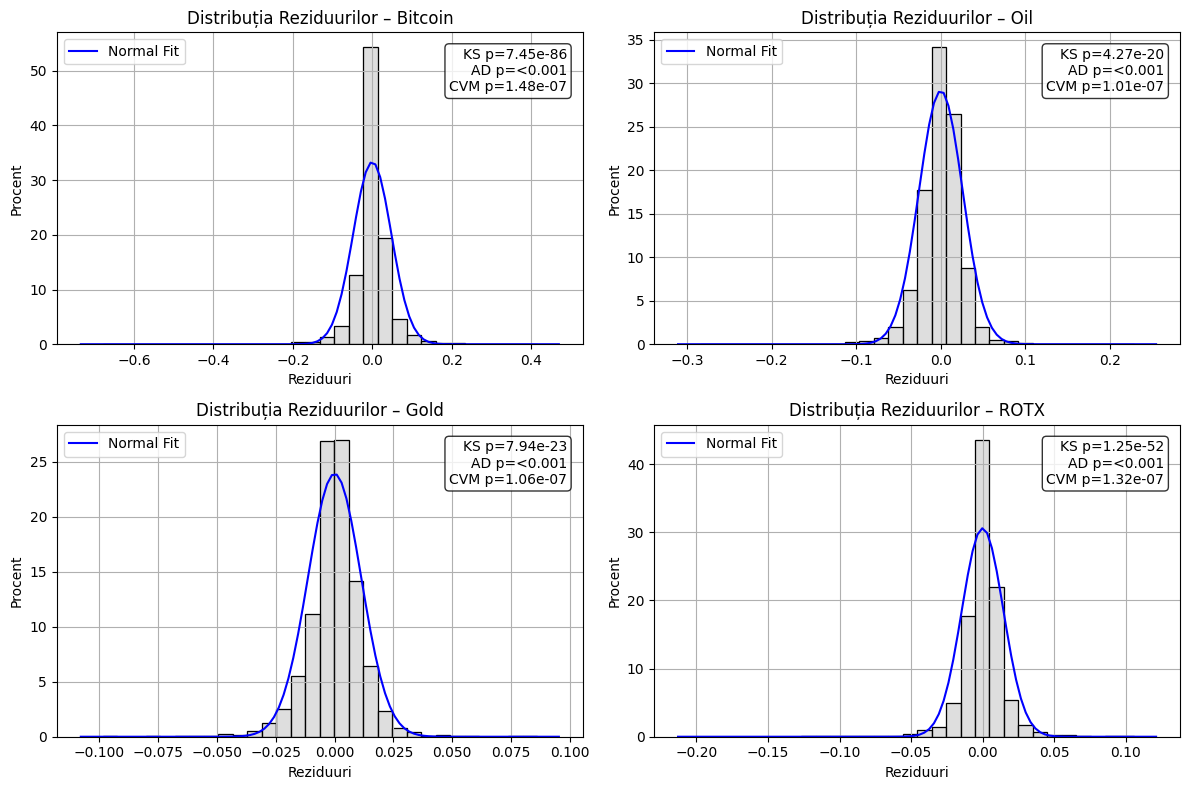

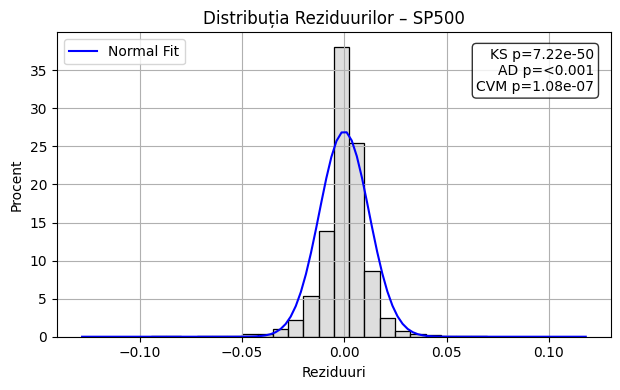

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_multiple_residuals(datasets, titles):
    """
    Plotează histograme + normal fit + p-values pe subplots.

    - datasets: listă de array-like sau pd.Series (reziduuri)
    - titles: listă de titluri (pentru fiecare grafic)
    """
    n = len(datasets)
    ncols = 2
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=(ncols*6, nrows*4))

    for i, (data, titlu) in enumerate(zip(datasets, titles), 1):
        data = pd.Series(data).dropna()
        z = (data - np.mean(data)) / np.std(data)

        plt.subplot(nrows, ncols, i)
        sns.histplot(data, bins=30, kde=False, stat='percent', color='lightgray')
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, np.mean(data), np.std(data))
        plt.plot(x, p * 100 * (xmax - xmin) / 30, 'b-', label='Normal Fit')
        plt.title(f"Distribuția Reziduurilor – {titlu}")
        plt.xlabel("Reziduuri")
        plt.ylabel("Procent")
        plt.legend()

        # Calculează testele și p-value-urile
        ks_stat, ks_p = stats.kstest(z, 'norm')
        cvm_result = stats.cramervonmises(data, 'norm')
        ad_result = stats.anderson(data, dist='norm')

        # Anderson nu dă direct p-value, estimăm aproximativ:
        # Regulă empirică: p < 0.001 dacă A² > critical_values[-1]
        ad_p = "<0.001" if ad_result.statistic > ad_result.critical_values[-1] else ">0.001"

        # Text pe grafic
        textstr = (
            f"KS p={ks_p:.3g}\n"
            f"AD p={ad_p}\n"
            f"CVM p={cvm_result.pvalue:.3g}"
        )
        plt.gca().text(0.97, 0.95, textstr, transform=plt.gca().transAxes,
                       verticalalignment='top', horizontalalignment='right',
                       fontsize=10, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Exemplu de apel
plot_multiple_residuals(
    datasets=[r_bitcoin, r_oil, r_gold, r_rotx],
    titles=["Bitcoin", "Oil", "Gold", "ROTX"]
)

plot_multiple_residuals(
    datasets=[r_sp500],
    titles=["SP500"]
)

# **GARCH FITTING**

In [29]:
from arch import arch_model
import pandas as pd

def compare_garch_models(series, p_range=range(1, 5), q_range=range(1, 5),
                          mean_type='Zero', show_summary=False):

    series = series.dropna()
    results = []

    vol_models = ['GARCH', 'EGARCH', 'FIGARCH']
    distributions = ['normal', 't', 'skewt', 'ged']

    for vol in vol_models:
        for dist in distributions:
            if vol == 'FIGARCH':
                p_iter = [1]
                q_iter = [1]
            else:
                p_iter = p_range
                q_iter = q_range

            for p in p_iter:
                for q in q_iter:
                    try:
                        model = arch_model(series, mean=mean_type, vol=vol, p=p, q=q, dist=dist)
                        fitted = model.fit(disp='off')

                        params = fitted.params
                        pvalues = fitted.pvalues
                        total_params = len(params)
                        significant = {k: v for k, v in pvalues.items() if v < 0.05}

                        results.append({
                            'Model Volatilitate': vol,
                            'Distribuție': dist,
                            'GARCH(p,q)': f'({p},{q})',
                            'AIC': fitted.aic,
                            'BIC': fitted.bic,
                            'LogLik': fitted.loglikelihood,
                            'Nr. Parametri': total_params,
                            'Parametri Semnificativi': len(significant),
                            'Coef. Semnificativi': list(significant.keys())
                        })

                        if show_summary:
                            print(f'Model: {vol}, dist: {dist}, p: {p}, q: {q}')
                            print(fitted.summary())

                    except Exception as e:
                        print(f"Eroare {vol}({p},{q}) [{dist}]: {e}")
                        continue

    df_results = pd.DataFrame(results)

    # Sortăm modelele întâi după "parametri semnificativi = număr total"
    df_results['All_Significant'] = df_results['Parametri Semnificativi'] == df_results['Nr. Parametri']

    # Mai întâi toate cele complet semnificative, apoi restul după AIC
    df_results = df_results.sort_values(by=['All_Significant', 'AIC'], ascending=[False, True]).reset_index(drop=True)

    return df_results


In [28]:
compare_garch_models(r_oil, show_summary=False)

,Model Volatilitate,Distribuție,"GARCH(p,q)",AIC,BIC,LogLik,Nr. Parametri,Parametri Semnificativi,Coef. Semnificativi,All_Significant
0,EGARCH,skewt,"(1,1)",-24752.404891,-24719.767194,12381.202446,5,5,"[omega, alpha[1], beta[1], eta, lambda]",True
1,EGARCH,skewt,"(2,2)",-24750.196373,-24704.503596,12382.098186,7,7,"[omega, alpha[1], alpha[2], beta[1], beta[2], ...",True
2,FIGARCH,skewt,"(1,1)",-24750.104365,-24710.939128,12381.052183,6,6,"[omega, phi, d, beta, eta, lambda]",True
3,GARCH,t,"(1,1)",-24711.148532,-24685.038374,12359.574266,4,4,"[omega, alpha[1], beta[1], nu]",True
4,FIGARCH,t,"(1,1)",-24707.951108,-24675.313411,12358.975554,5,5,"[omega, phi, d, beta, nu]",True
...,...,...,...,...,...,...,...,...,...,...
127,GARCH,normal,"(3,1)",-24455.209123,-24422.571425,12232.604561,5,2,"[omega, beta[1]]",False
128,GARCH,normal,"(4,3)",-24453.901708,-24401.681392,12234.950854,8,2,"[omega, alpha[1]]",False
129,GARCH,normal,"(3,2)",-24453.221579,-24414.056342,12232.610789,6,2,"[omega, alpha[1]]",False
130,GARCH,normal,"(4,2)",-24434.372166,-24388.679389,12224.186083,7,3,"[omega, alpha[1], alpha[2]]",False


In [30]:
compare_garch_models(r_bitcoin, show_summary=False)

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,Model Volatilitate,Distribuție,"GARCH(p,q)",AIC,BIC,LogLik,Nr. Parametri,Parametri Semnificativi,Coef. Semnificativi,All_Significant
0,EGARCH,ged,"(2,1)",-21824.434390,-21791.435918,10917.217195,5,5,"[omega, alpha[1], alpha[2], beta[1], nu]",True
1,EGARCH,ged,"(1,2)",-21809.530959,-21776.532487,10909.765479,5,5,"[omega, alpha[1], beta[1], beta[2], nu]",True
2,EGARCH,ged,"(1,1)",-21795.794860,-21769.396082,10901.897430,4,4,"[omega, alpha[1], beta[1], nu]",True
3,GARCH,ged,"(1,2)",-21127.073316,-21094.074844,10568.536658,5,5,"[omega, alpha[1], beta[1], beta[2], nu]",True
4,EGARCH,normal,"(1,2)",-20120.320238,-20093.921460,10064.160119,4,4,"[omega, alpha[1], beta[1], beta[2]]",True
...,...,...,...,...,...,...,...,...,...,...
127,GARCH,normal,"(4,3)",-19928.170070,-19875.372514,9972.085035,8,0,[],False
128,GARCH,normal,"(3,2)",-19916.712937,-19877.114771,9964.356469,6,0,[],False
129,GARCH,normal,"(3,1)",-19901.345468,-19868.346996,9955.672734,5,3,"[omega, alpha[1], beta[1]]",False
130,GARCH,normal,"(4,2)",-19864.286190,-19818.088329,9939.143095,7,2,"[omega, alpha[1]]",False


In [31]:
compare_garch_models(r_gold, show_summary=False)

,Model Volatilitate,Distribuție,"GARCH(p,q)",AIC,BIC,LogLik,Nr. Parametri,Parametri Semnificativi,Coef. Semnificativi,All_Significant
0,EGARCH,skewt,"(1,1)",-29982.028552,-29949.753027,14996.014276,5,5,"[omega, alpha[1], beta[1], eta, lambda]",True
1,EGARCH,t,"(1,1)",-29971.458276,-29945.637856,14989.729138,4,4,"[omega, alpha[1], beta[1], nu]",True
2,EGARCH,ged,"(1,1)",-29950.302448,-29924.482028,14979.151224,4,4,"[omega, alpha[1], beta[1], nu]",True
3,GARCH,t,"(1,1)",-29934.667520,-29908.847100,14971.333760,4,4,"[omega, alpha[1], beta[1], nu]",True
4,GARCH,t,"(1,2)",-29929.240287,-29896.964762,14969.620144,5,5,"[omega, alpha[1], beta[1], beta[2], nu]",True
...,...,...,...,...,...,...,...,...,...,...
127,GARCH,normal,"(4,2)",-29529.754492,-29484.568757,14771.877246,7,1,[omega],False
128,GARCH,normal,"(1,3)",-29527.419421,-29495.143896,14768.709711,5,2,"[omega, alpha[1]]",False
129,GARCH,normal,"(4,1)",-29517.150935,-29478.420305,14764.575468,6,2,"[omega, beta[1]]",False
130,GARCH,normal,"(1,4)",-29516.725430,-29477.994800,14764.362715,6,2,"[omega, alpha[1]]",False


In [32]:
compare_garch_models(r_rotx, show_summary=False)

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,Model Volatilitate,Distribuție,"GARCH(p,q)",AIC,BIC,LogLik,Nr. Parametri,Parametri Semnificativi,Coef. Semnificativi,All_Significant
0,FIGARCH,t,"(1,1)",-31438.749351,-31406.155391,15724.374676,5,5,"[omega, phi, d, beta, nu]",True
1,EGARCH,skewt,"(2,1)",-31416.560957,-31377.448205,15714.280478,6,6,"[omega, alpha[1], alpha[2], beta[1], eta, lambda]",True
2,EGARCH,skewt,"(1,2)",-31403.552165,-31364.439414,15707.776083,6,6,"[omega, alpha[1], beta[1], beta[2], eta, lambda]",True
3,EGARCH,t,"(2,1)",-31390.952927,-31358.358968,15700.476464,5,5,"[omega, alpha[1], alpha[2], beta[1], nu]",True
4,EGARCH,skewt,"(1,1)",-31384.081428,-31351.487469,15697.040714,5,5,"[omega, alpha[1], beta[1], eta, lambda]",True
...,...,...,...,...,...,...,...,...,...,...
127,GARCH,normal,"(4,4)",-30598.042225,-30539.373098,15308.021113,9,1,[omega],False
128,GARCH,normal,"(3,1)",-30592.555551,-30559.961592,15301.277776,5,4,"[omega, alpha[1], alpha[3], beta[1]]",False
129,GARCH,normal,"(4,3)",-30582.607373,-30530.457037,15299.303686,8,1,[omega],False
130,GARCH,normal,"(4,2)",-30557.625212,-30511.993669,15285.812606,7,2,"[omega, alpha[1]]",False


In [18]:
compare_garch_models(r_sp500, show_summary=False)

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,Model Volatilitate,Distribuție,"GARCH(p,q)",AIC,BIC,LogLik,Nr. Parametri,Parametri Semnificativi,Coef. Semnificativi,All_Significant
0,EGARCH,skewt,"(2,1)",-33670.567936,-33631.335382,16841.283968,6,6,"[omega, alpha[1], alpha[2], beta[1], eta, lambda]",True
1,EGARCH,skewt,"(1,1)",-33663.130304,-33630.436509,16836.565152,5,5,"[omega, alpha[1], beta[1], eta, lambda]",True
2,GARCH,t,"(3,1)",-33594.088951,-33554.856397,16803.044476,6,6,"[omega, alpha[1], alpha[2], alpha[3], beta[1],...",True
3,GARCH,t,"(2,1)",-33588.025300,-33555.331505,16799.012650,5,5,"[omega, alpha[1], alpha[2], beta[1], nu]",True
4,GARCH,t,"(4,1)",-33587.954127,-33542.182814,16800.977064,7,7,"[omega, alpha[1], alpha[2], alpha[3], alpha[4]...",True
...,...,...,...,...,...,...,...,...,...,...
127,EGARCH,normal,"(1,3)",-33273.272489,-33240.578694,16641.636245,5,3,"[omega, alpha[1], beta[1]]",False
128,EGARCH,normal,"(1,4)",-33271.272490,-33232.039936,16641.636245,6,0,[],False
129,EGARCH,normal,"(3,4)",-33268.123630,-33215.813558,16642.061815,8,3,"[omega, alpha[1], beta[3]]",False
130,GARCH,normal,"(3,4)",-33266.995192,-33214.685120,16641.497596,8,1,[omega],False
